In [1]:
!pip install numpy pandas scikit-learn matplotlib seaborn umap-learn
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/fmldata/data.csv")

In [3]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

identifier_cols = [col for col in data.columns if data[col].nunique() == len(data)]
print("Identifier columns:", identifier_cols)
data = data.drop(columns=identifier_cols)

numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()
corr_matrix = data[numeric_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.90)]
data = data.drop(columns=to_drop_corr)

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
if "loan_status" in categorical_cols:
    categorical_cols.remove("loan_status")
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
data[categorical_cols] = enc.fit_transform(data[categorical_cols])

if "loan_status" in data.columns:
    data = data.drop(columns=["loan_status"])

bool_like_cols = []
for col in data.columns:
    unique_vals = set(str(v).lower() for v in data[col].dropna().unique())
    if unique_vals.issubset({"true","false","t","f","yes","no","y","n"}):
        bool_like_cols.append(col)

for col in bool_like_cols:
    data[col] = data[col].astype(str).str.lower().map({
        "true":1,"t":1,"yes":1,"y":1,
        "false":0,"f":0,"no":0,"n":0
    }).astype(int)

noerror_data = data.copy()
print("Baseline dataset created.")
print(noerror_data.shape)

X = noerror_data.drop(columns=["default_binary"])
y = noerror_data["default_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Decision Tree preprocessing complete. Ready for model training.")

Identifier columns: []
Baseline dataset created.
(10000, 74)
Train: (7500, 73) Test: (2500, 73)
Decision Tree preprocessing complete. Ready for model training.


In [4]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    random_state=42
)

dt.fit(X_train, y_train)

results = {
    "baseline_dt": {}
}

print("Baseline Decision Tree trained.")

Baseline Decision Tree trained.


max_depth=1: Train=0.8391, Test=0.8332
max_depth=2: Train=0.8391, Test=0.8332
max_depth=3: Train=0.9223, Test=0.9240
max_depth=4: Train=0.9332, Test=0.9288
max_depth=5: Train=0.9480, Test=0.9476
max_depth=7: Train=0.9725, Test=0.9644
max_depth=10: Train=0.9975, Test=0.9752
max_depth=15: Train=1.0000, Test=0.9724
max_depth=20: Train=1.0000, Test=0.9724
max_depth=30: Train=1.0000, Test=0.9724


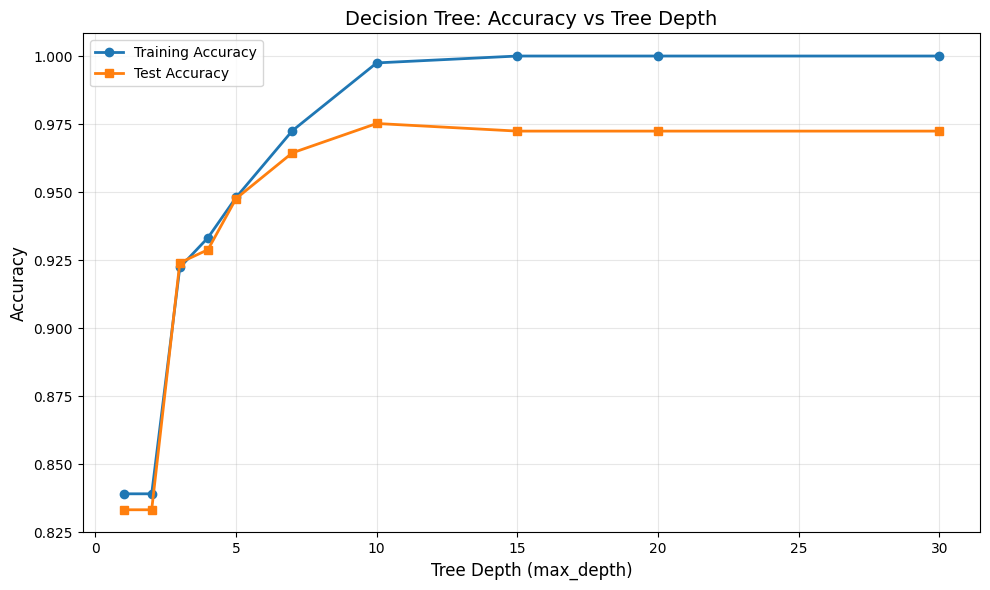


Best max_depth: 10 with Test Accuracy: 0.9752


In [5]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

max_depth_range = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30]
train_accuracies = []
test_accuracies = []

for depth in max_depth_range:
    dt_temp = DecisionTreeClassifier(
        max_depth=depth,
        random_state=42
    )
    dt_temp.fit(X_train, y_train)

    train_acc = dt_temp.score(X_train, y_train)
    test_acc = dt_temp.score(X_test, y_test)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"max_depth={depth}: Train={train_acc:.4f}, Test={test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_accuracies, marker='o', label='Training Accuracy', linewidth=2)
plt.plot(max_depth_range, test_accuracies, marker='s', label='Test Accuracy', linewidth=2)
plt.xlabel('Tree Depth (max_depth)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Decision Tree: Accuracy vs Tree Depth', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_idx = test_accuracies.index(max(test_accuracies))
best_depth = max_depth_range[best_idx]
print(f"\nBest max_depth: {best_depth} with Test Accuracy: {test_accuracies[best_idx]:.4f}")

In [6]:
from sklearn.metrics import accuracy_score

y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

results["baseline_dt"]["train_accuracy"] = train_acc
results["baseline_dt"]["test_accuracy"] = test_acc
results["baseline_dt"]["train_predictions"] = y_train_pred
results["baseline_dt"]["test_predictions"] = y_test_pred

print("=" * 50)
print("DECISION TREE MODEL ACCURACY")
print("=" * 50)
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy:     {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Difference:        {(train_acc - test_acc):.4f}")
print("=" * 50)

DECISION TREE MODEL ACCURACY
Training Accuracy: 1.0000 (100.00%)
Test Accuracy:     0.9724 (97.24%)
Difference:        0.0276


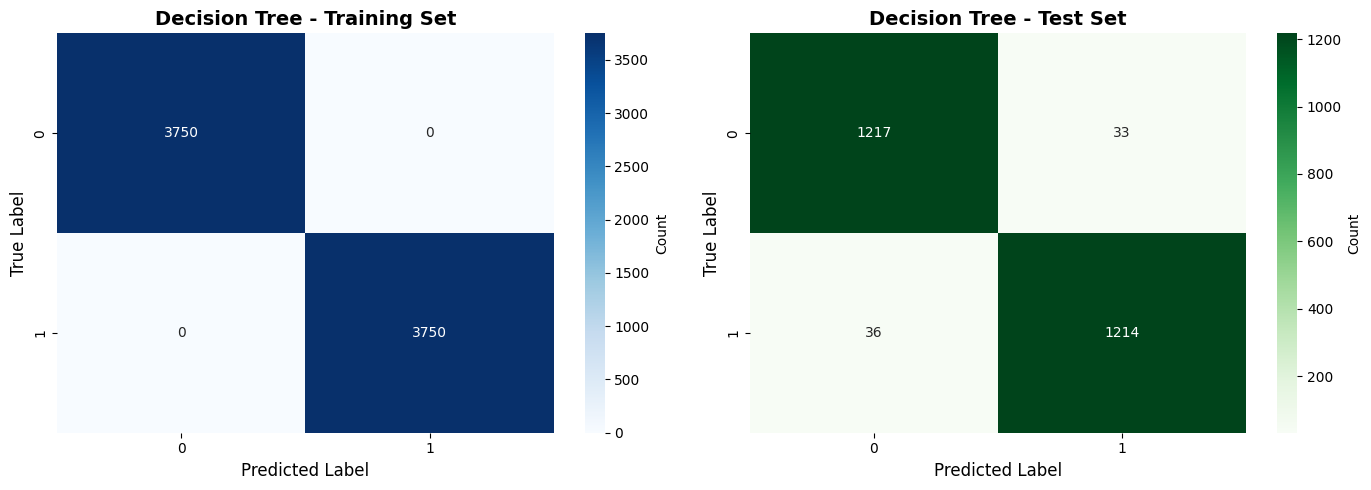

Confusion Matrix - Training Set:
[[3750    0]
 [   0 3750]]

Confusion Matrix - Test Set:
[[1217   33]
 [  36 1214]]


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Decision Tree - Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            cbar_kws={'label': 'Count'})
axes[1].set_title('Decision Tree - Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

print("Confusion Matrix - Training Set:")
print(cm_train)
print("\nConfusion Matrix - Test Set:")
print(cm_test)

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

results["baseline_dt"]["train_precision"] = train_precision
results["baseline_dt"]["train_recall"] = train_recall
results["baseline_dt"]["train_f1"] = train_f1
results["baseline_dt"]["test_precision"] = test_precision
results["baseline_dt"]["test_recall"] = test_recall
results["baseline_dt"]["test_f1"] = test_f1

print("=" * 60)
print("PRECISION / RECALL / F1-SCORE")
print("=" * 60)
print("\nTRAINING SET:")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")

print("\nTEST SET:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print("=" * 60)

print("\n\nDETAILED CLASSIFICATION REPORT - TEST SET:")
print(classification_report(y_test, y_test_pred, target_names=['No Default', 'Default']))

PRECISION / RECALL / F1-SCORE

TRAINING SET:
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

TEST SET:
  Precision: 0.9735
  Recall:    0.9712
  F1-Score:  0.9724


DETAILED CLASSIFICATION REPORT - TEST SET:
              precision    recall  f1-score   support

  No Default       0.97      0.97      0.97      1250
     Default       0.97      0.97      0.97      1250

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



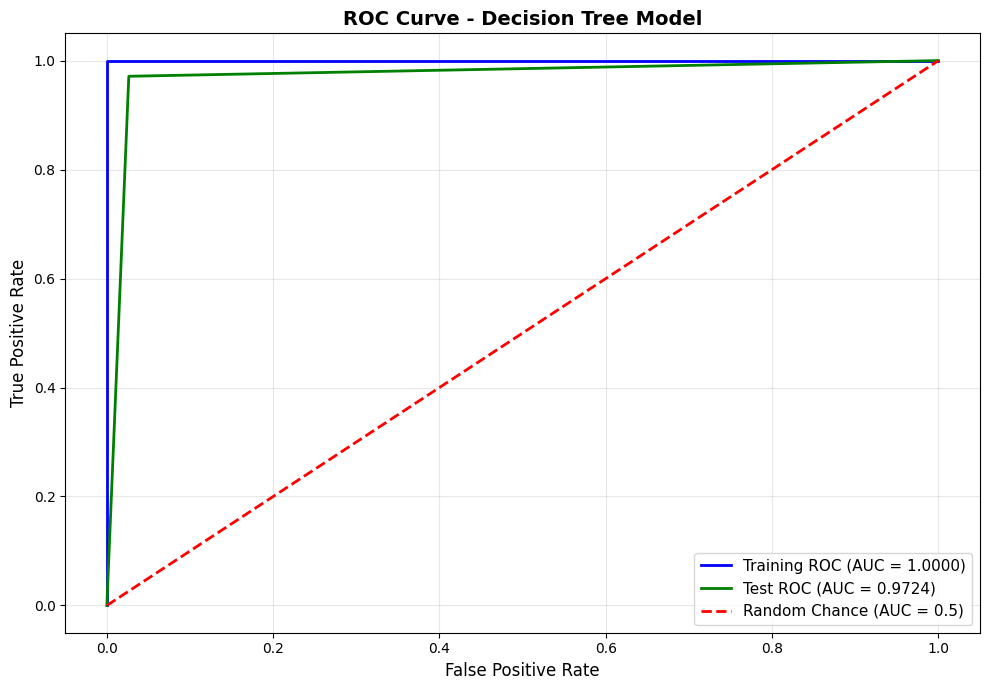

ROC-AUC SCORES
Training AUC: 1.0000
Test AUC:     0.9724


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_train_proba = dt.predict_proba(X_train)[:, 1]
y_test_proba = dt.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

results["baseline_dt"]["train_auc"] = train_auc
results["baseline_dt"]["test_auc"] = test_auc

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {train_auc:.4f})',
         linewidth=2, color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {test_auc:.4f})',
         linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'r--', label='Random Chance (AUC = 0.5)', linewidth=2)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Decision Tree Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 50)
print("ROC-AUC SCORES")
print("=" * 50)
print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC:     {test_auc:.4f}")
print("=" * 50)

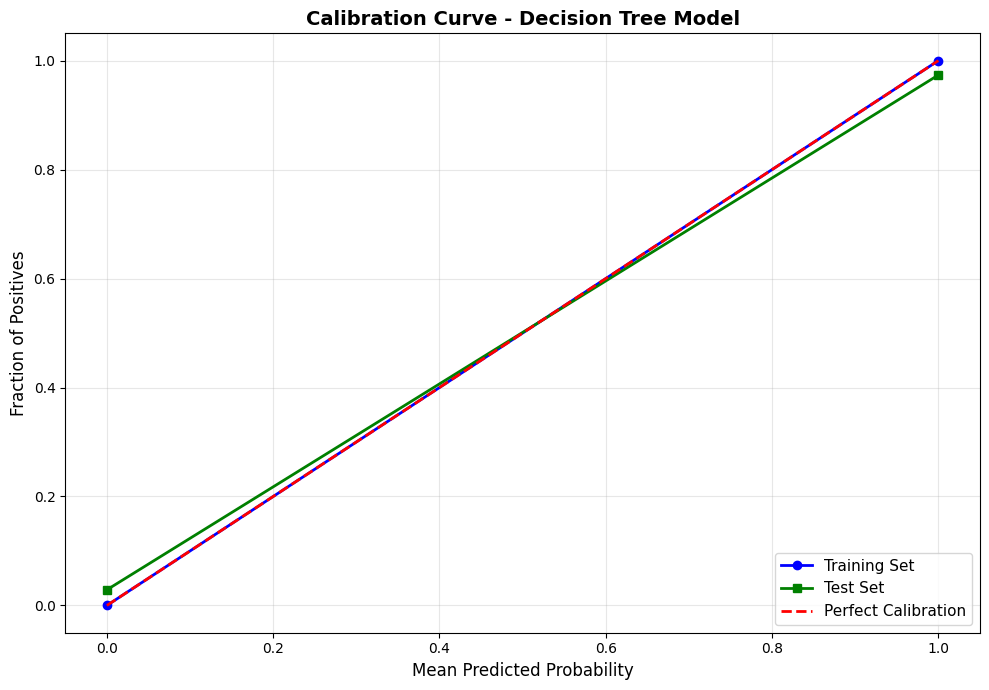

CALIBRATION CURVE ANALYSIS
A well-calibrated model's curve follows the diagonal line.
Points above the line indicate under-confidence.
Points below the line indicate over-confidence.


In [10]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_proba, n_bins=10)
prob_true_test, prob_pred_test = calibration_curve(y_test, y_test_proba, n_bins=10)

plt.figure(figsize=(10, 7))
plt.plot(prob_pred_train, prob_true_train, marker='o', linewidth=2,
         label='Training Set', color='blue')
plt.plot(prob_pred_test, prob_true_test, marker='s', linewidth=2,
         label='Test Set', color='green')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.title('Calibration Curve - Decision Tree Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 50)
print("CALIBRATION CURVE ANALYSIS")
print("=" * 50)
print("A well-calibrated model's curve follows the diagonal line.")
print("Points above the line indicate under-confidence.")
print("Points below the line indicate over-confidence.")
print("=" * 50)

symmetric noise

Original label distribution: [3750 3750]
Noisy label distribution:    [3770 3730]

DECISION TREE WITH 10% SYMMETRIC NOISE
Accuracy:  0.8596
Precision: 0.8548
Recall:    0.8664
F1 Score:  0.8605
AUC Score: 0.8596



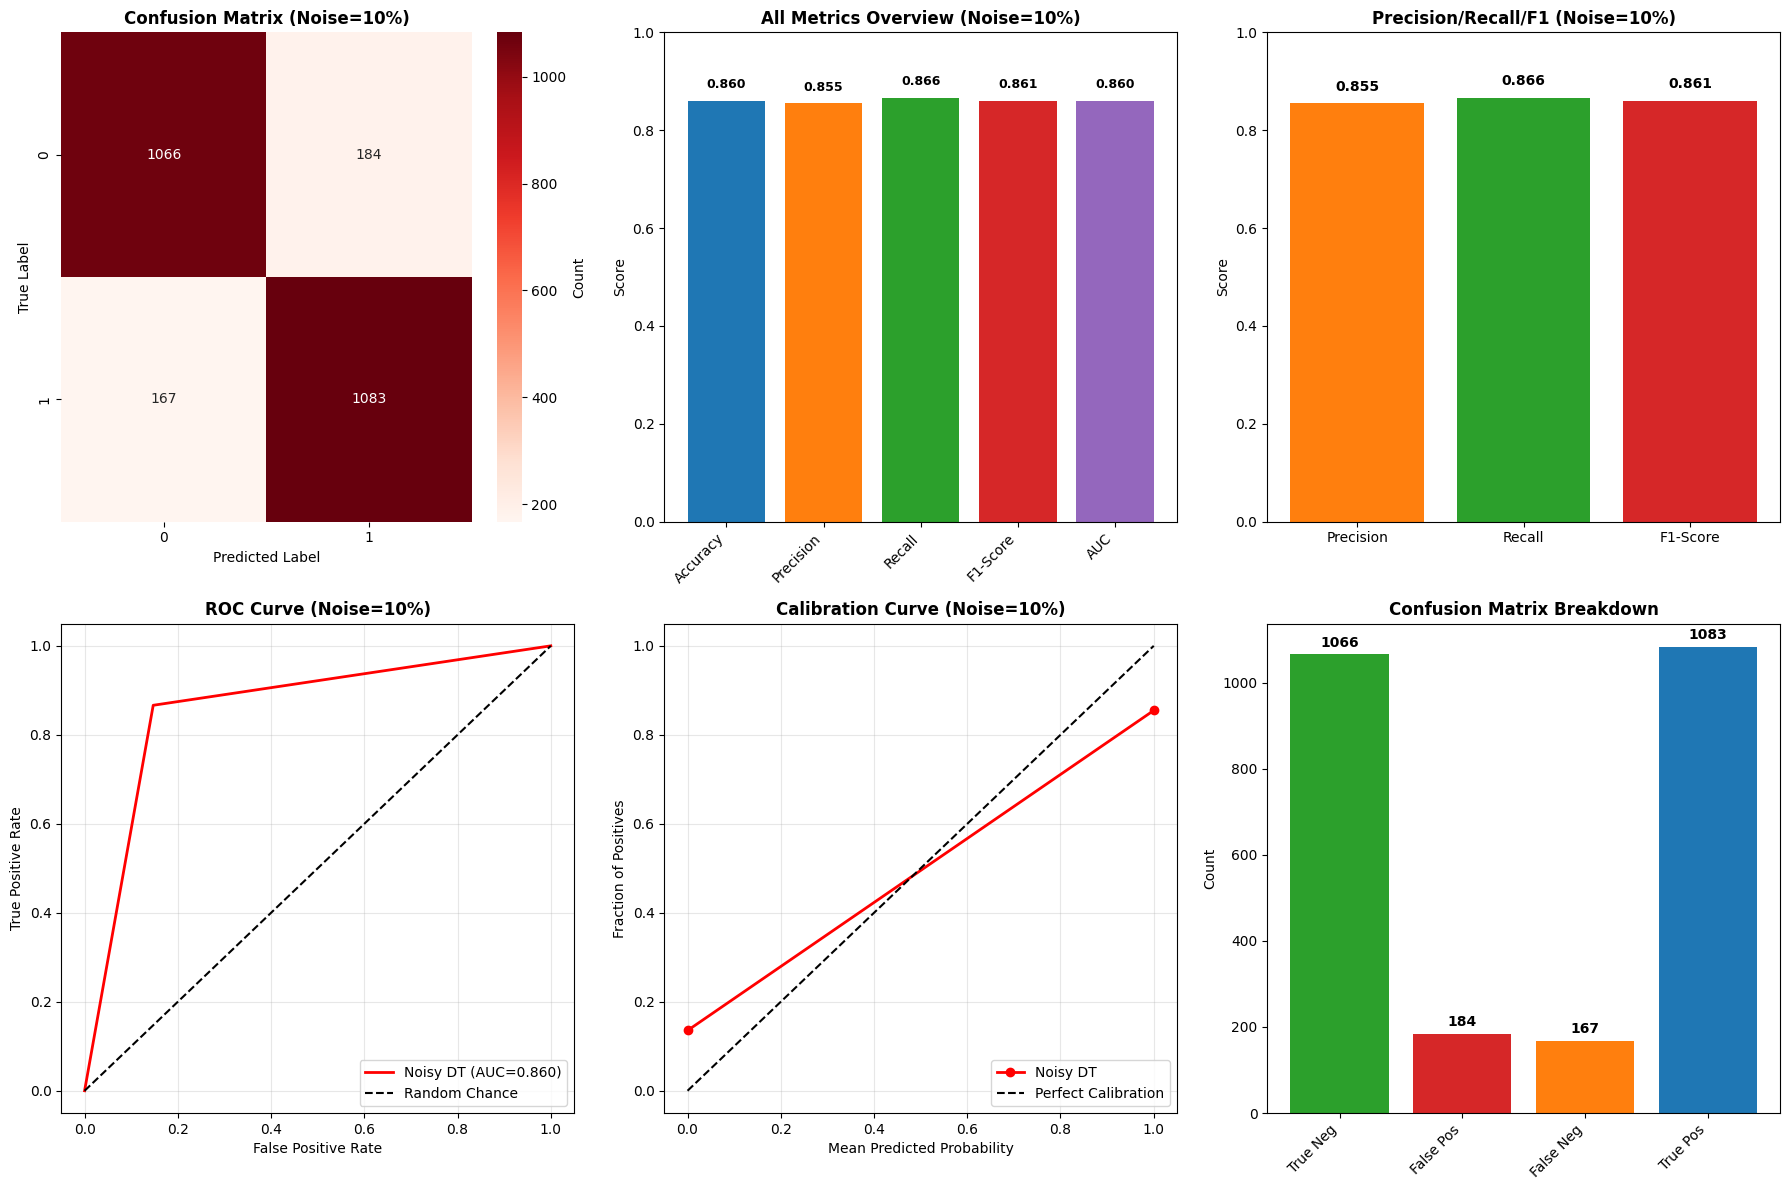


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.86      0.85      0.86      1250
     Default       0.85      0.87      0.86      1250

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

p = 0.10
y_train_noisy = inject_symmetric_noise(y_train, noise_rate=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:   ", np.bincount(y_train_noisy))

dt_noisy = DecisionTreeClassifier(random_state=42)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Noisy label distribution: [3752 3748]

DECISION TREE WITH 20% SYMMETRIC NOISE
Accuracy:  0.7676
Precision: 0.7571
Recall:    0.7880
F1 Score:  0.7722
AUC Score: 0.7676



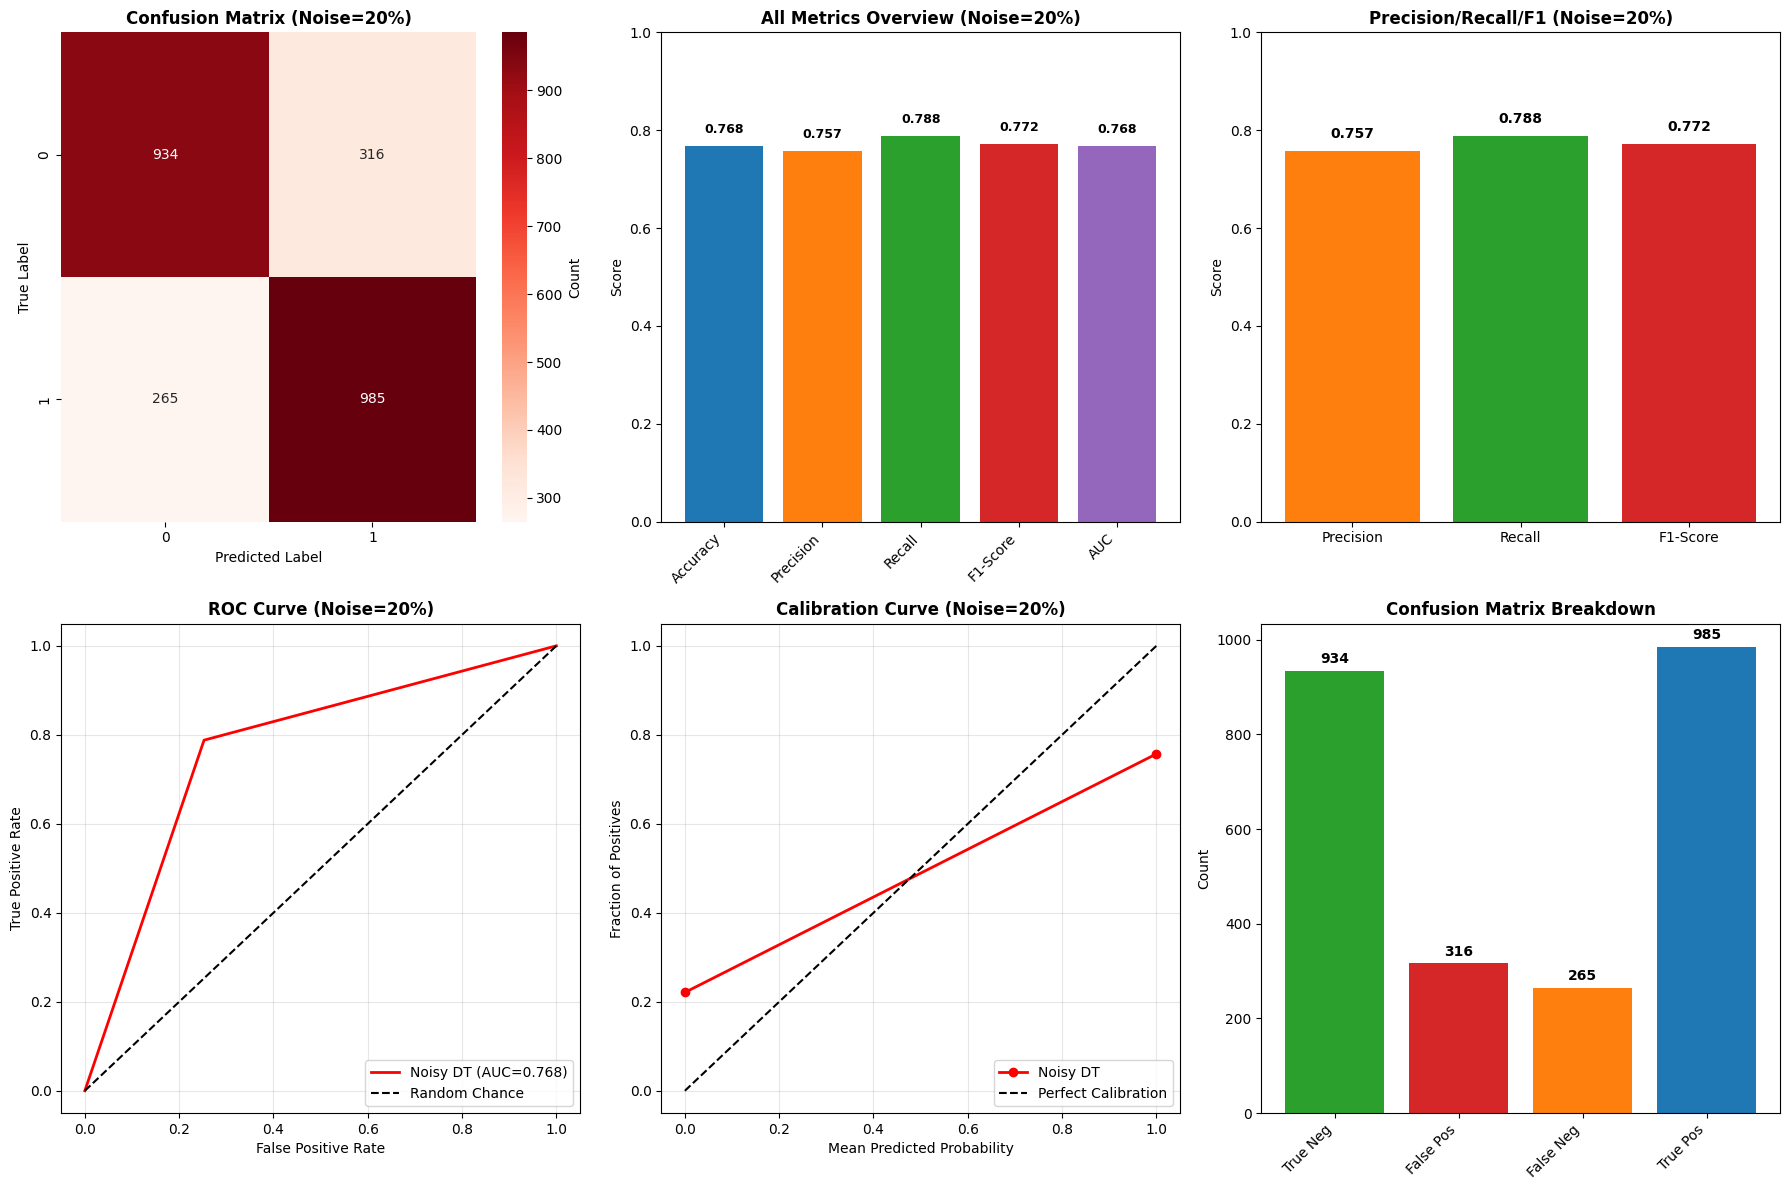


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.78      0.75      0.76      1250
     Default       0.76      0.79      0.77      1250

    accuracy                           0.77      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.77      0.77      0.77      2500



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

p = 0.20
y_train_noisy = inject_symmetric_noise(y_train, noise_rate=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:", np.bincount(y_train_noisy))

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Noisy label distribution: [3743 3757]

DECISION TREE WITH 33% SYMMETRIC NOISE
Accuracy:  0.6528
Precision: 0.6478
Recall:    0.6696
F1 Score:  0.6585
AUC Score: 0.6528



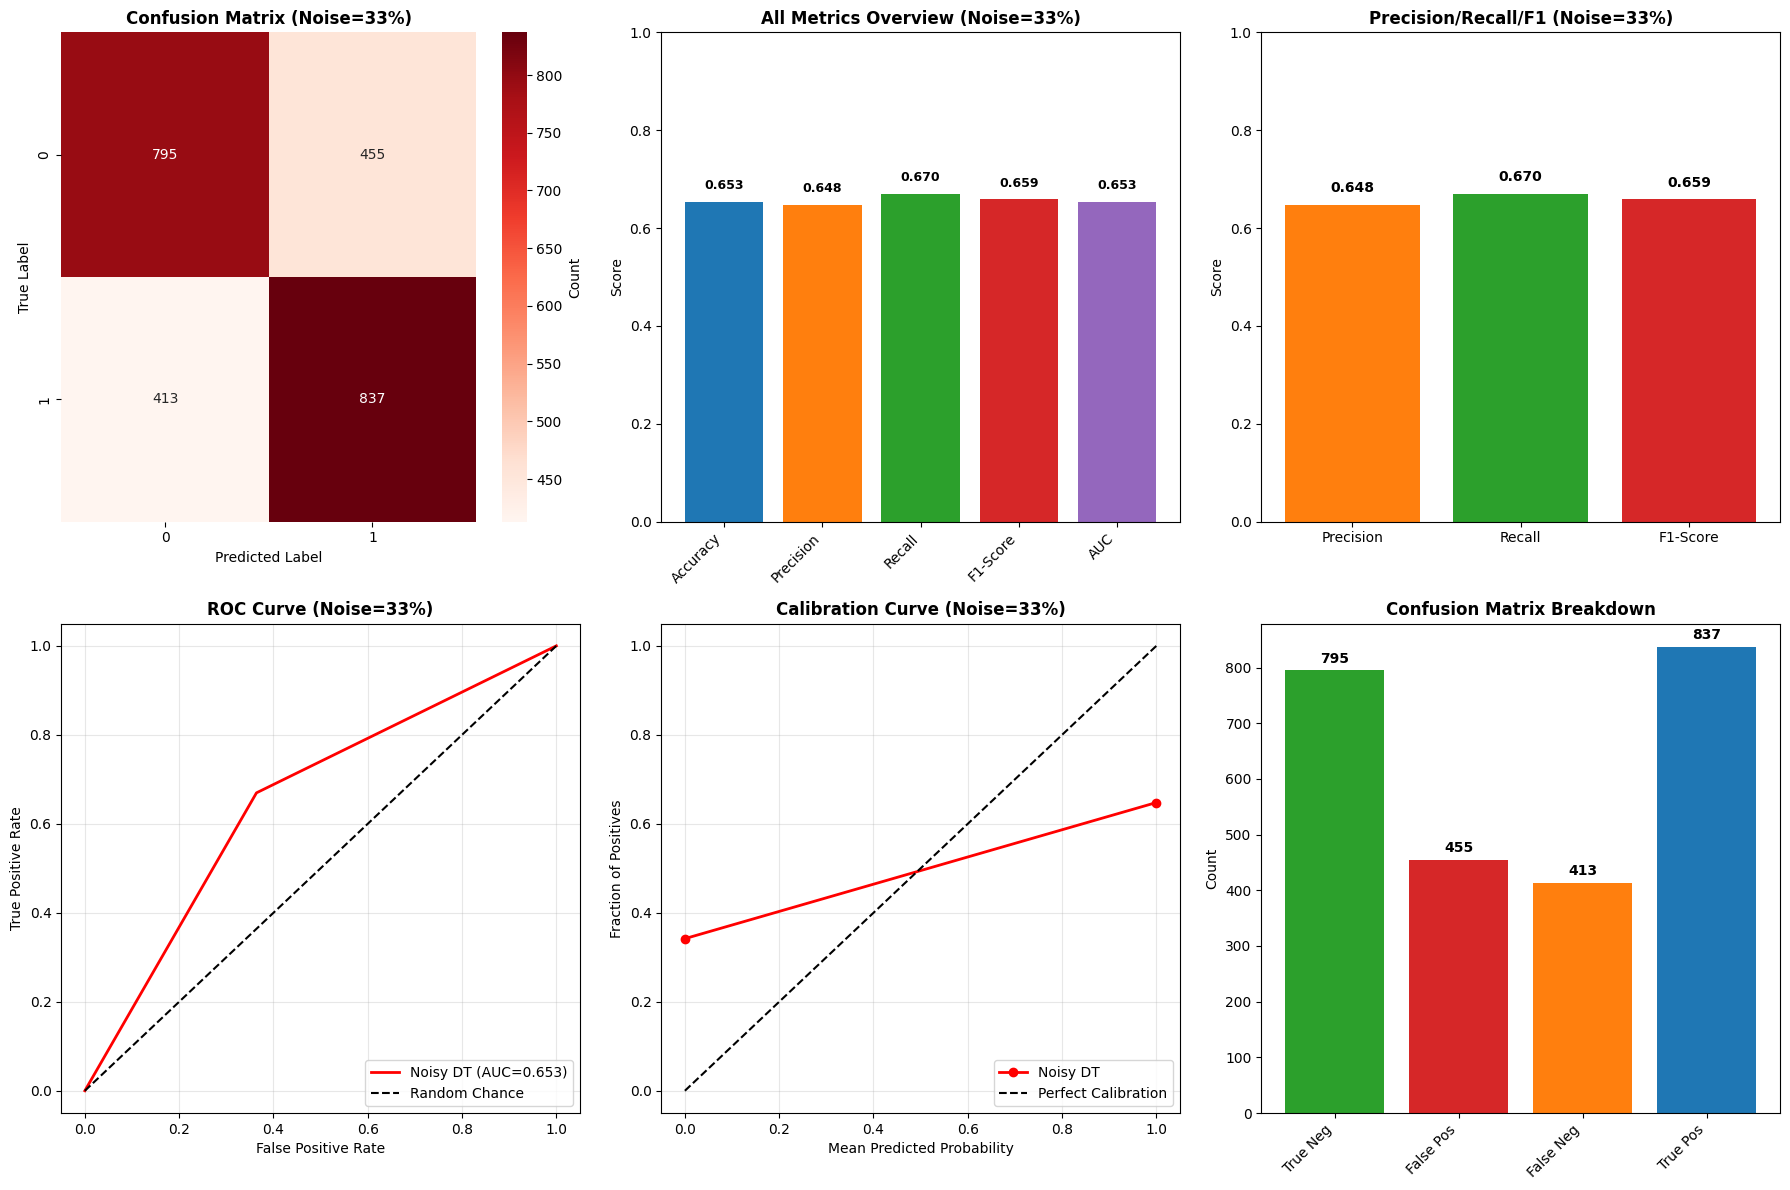


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.66      0.64      0.65      1250
     Default       0.65      0.67      0.66      1250

    accuracy                           0.65      2500
   macro avg       0.65      0.65      0.65      2500
weighted avg       0.65      0.65      0.65      2500



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

p = 0.33
y_train_noisy = inject_symmetric_noise(y_train, noise_rate=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:", np.bincount(y_train_noisy))

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Noisy label distribution: [3826 3674]

DECISION TREE WITH 50% SYMMETRIC NOISE
Accuracy:  0.5052
Precision: 0.5051
Recall:    0.5104
F1 Score:  0.5078
AUC Score: 0.5052



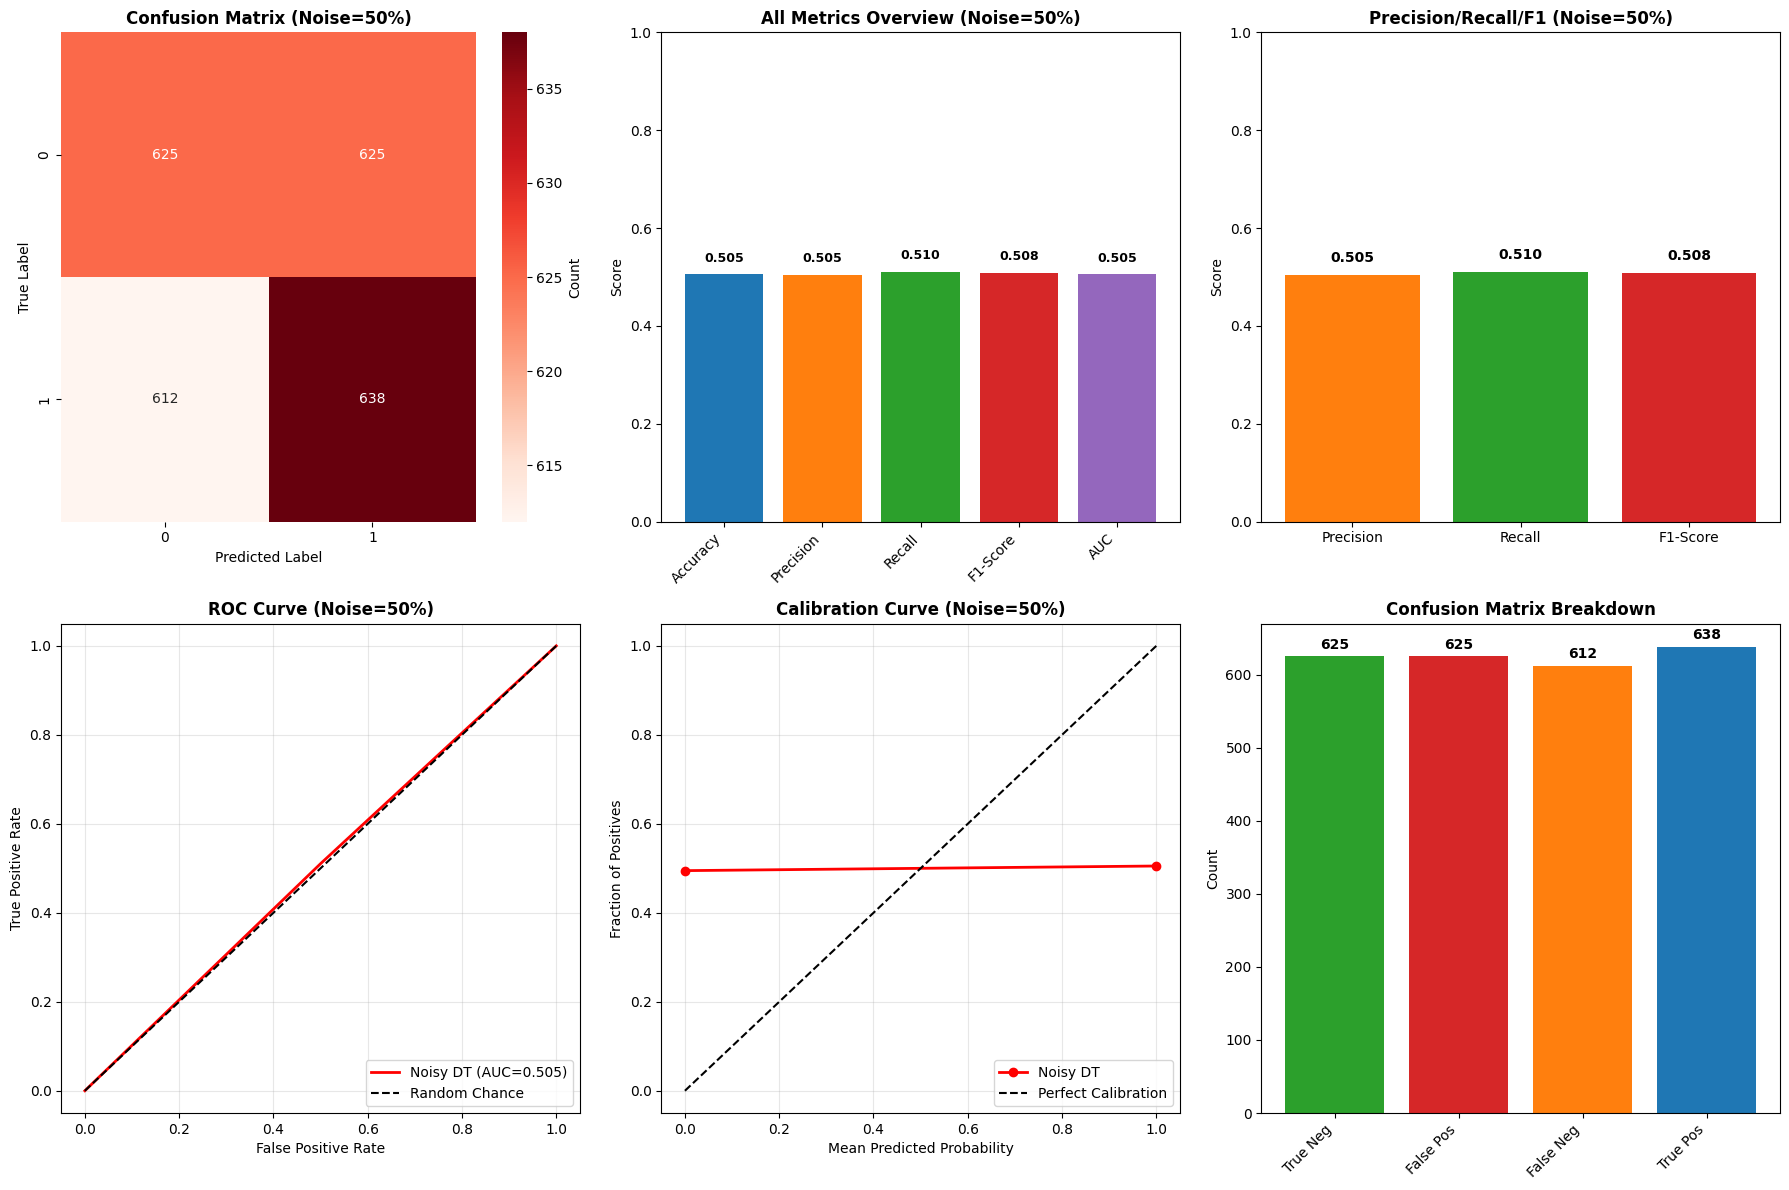


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.51      0.50      0.50      1250
     Default       0.51      0.51      0.51      1250

    accuracy                           0.51      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.51      0.51      0.51      2500



In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

p = 0.50
y_train_noisy = inject_symmetric_noise(y_train, noise_rate=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:", np.bincount(y_train_noisy))

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

asymmetrical noise

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [3375 4125]
Flipped class 0 -> 1 at rate 0.1

DECISION TREE WITH 10% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.9148
Precision: 0.8690
Recall:    0.9768
F1 Score:  0.9198
AUC Score: 0.9148



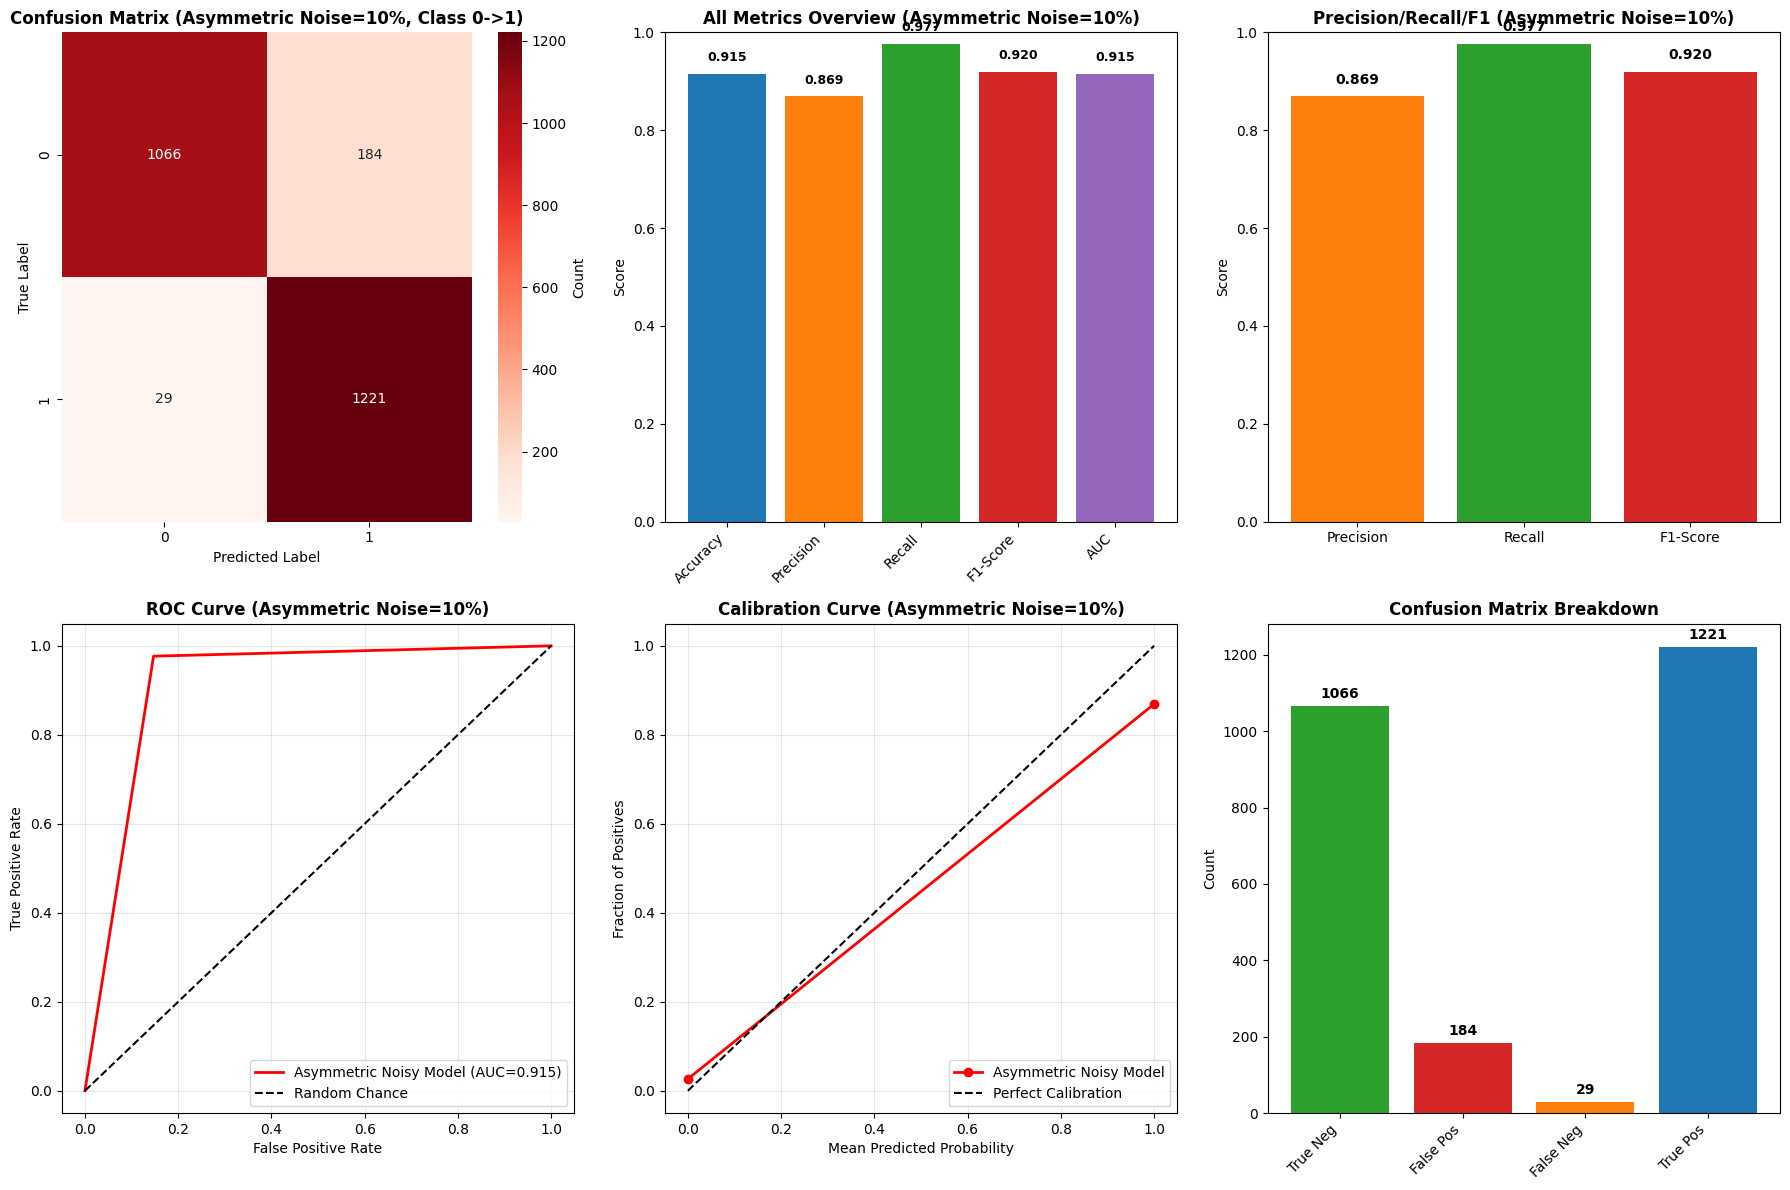


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.97      0.85      0.91      1250
     Default       0.87      0.98      0.92      1250

    accuracy                           0.91      2500
   macro avg       0.92      0.91      0.91      2500
weighted avg       0.92      0.91      0.91      2500



In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx = np.where(y_noisy == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 0
p = 0.10
y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [3000 4500]
Flipped class 0 -> 1 at rate 0.2

DECISION TREE WITH 20% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.8580
Precision: 0.7863
Recall:    0.9832
F1 Score:  0.8738
AUC Score: 0.8580



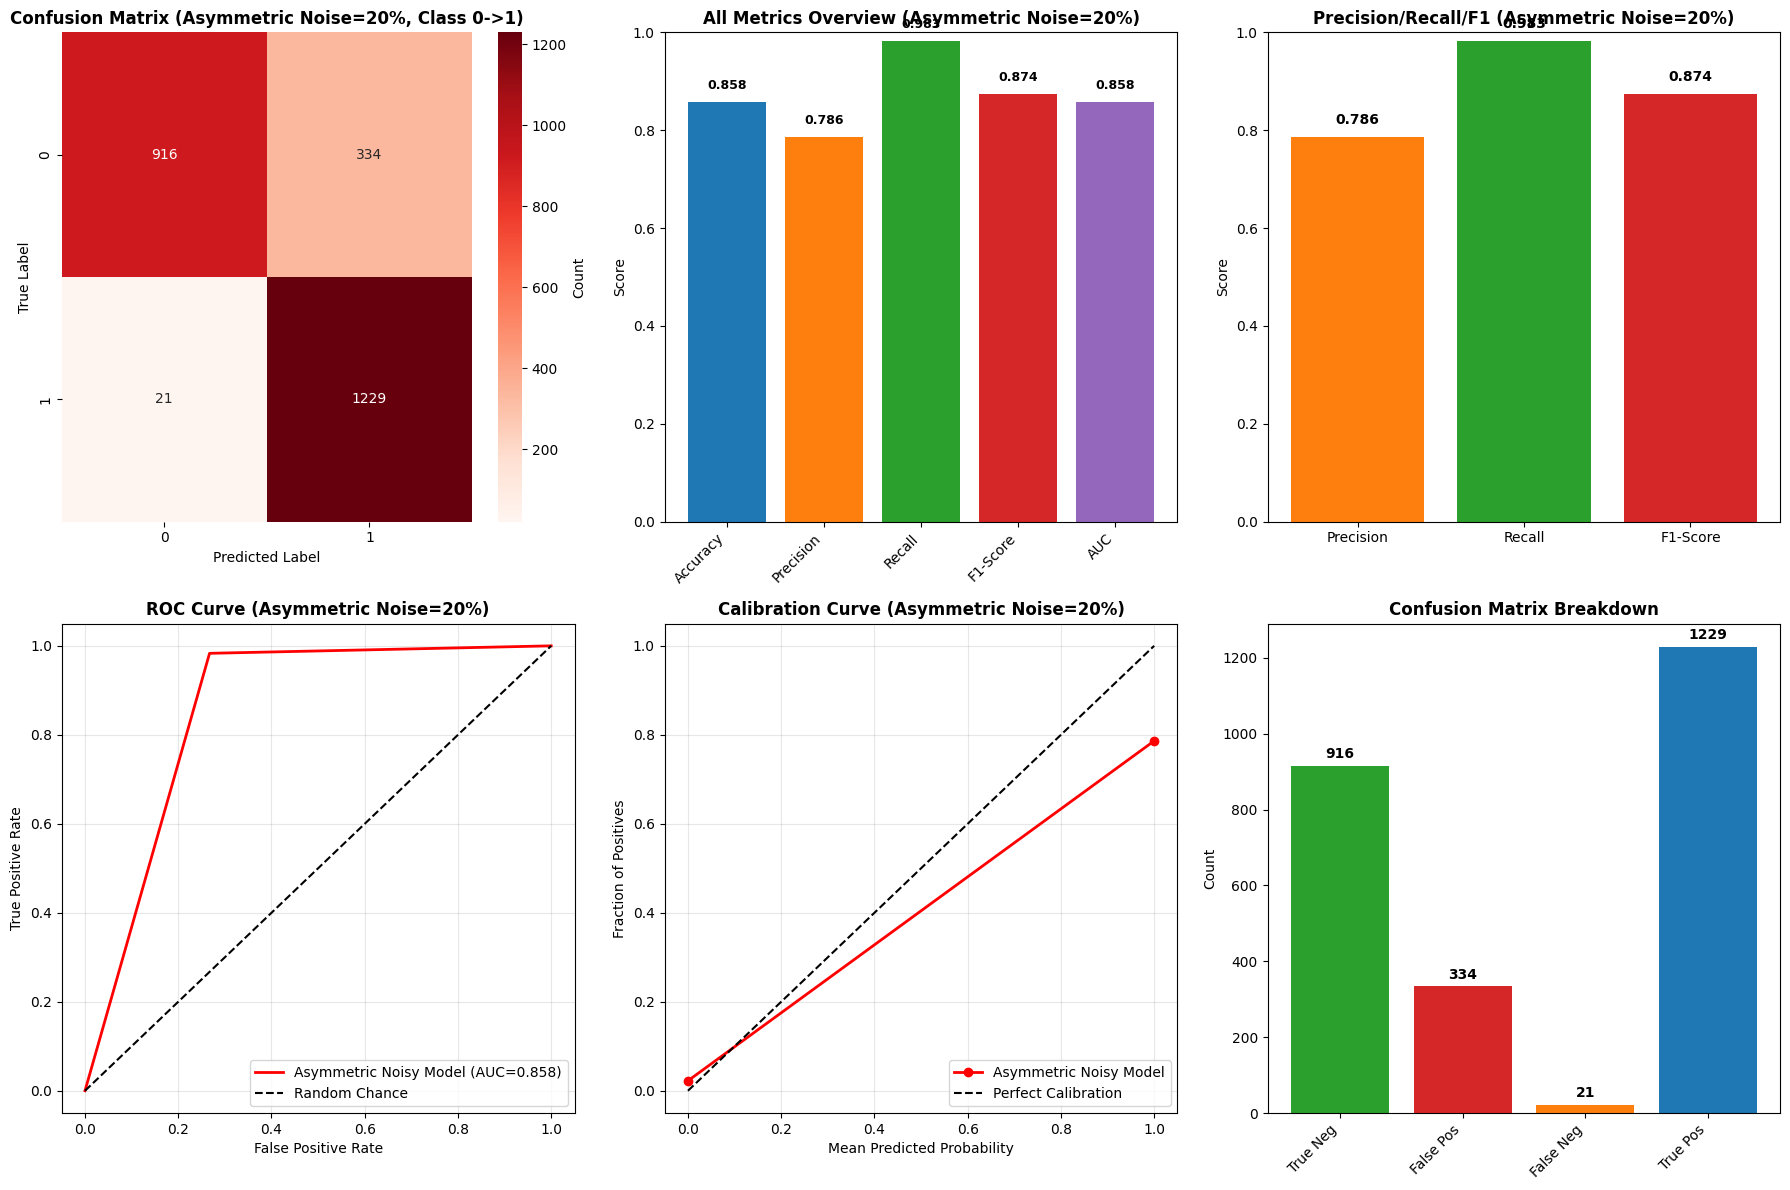


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.98      0.73      0.84      1250
     Default       0.79      0.98      0.87      1250

    accuracy                           0.86      2500
   macro avg       0.88      0.86      0.86      2500
weighted avg       0.88      0.86      0.86      2500



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx = np.where(y_noisy == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 0
p = 0.20
y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [2513 4987]
Flipped class 0 -> 1 at rate 0.33

DECISION TREE WITH 33% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.8000
Precision: 0.7196
Recall:    0.9832
F1 Score:  0.8310
AUC Score: 0.8000



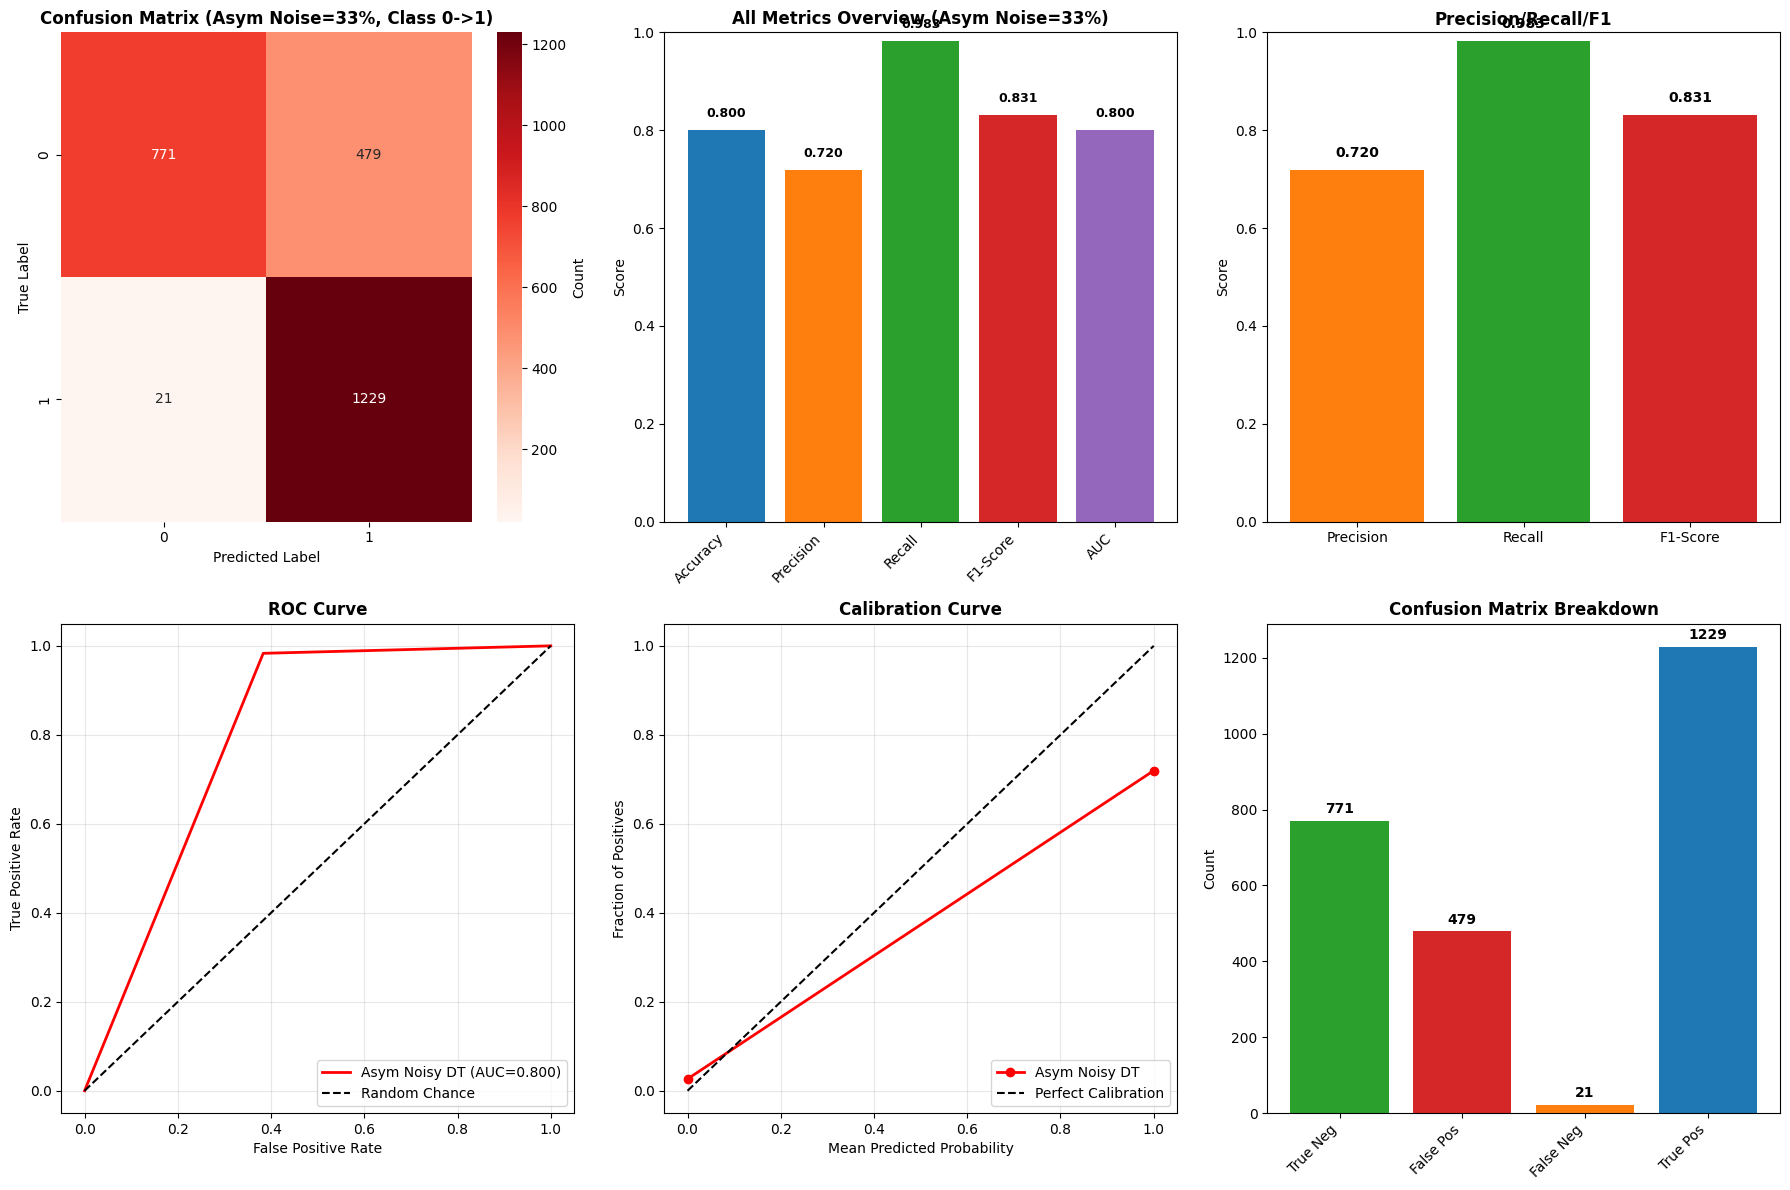


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.97      0.62      0.76      1250
     Default       0.72      0.98      0.83      1250

    accuracy                           0.80      2500
   macro avg       0.85      0.80      0.79      2500
weighted avg       0.85      0.80      0.79      2500



In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    # Ensure integer type to prevent TypeError
    y_noisy = np.array(y).copy().astype(int)

    idx = np.where(y_noisy == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)

    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip

    return y_noisy

class_to_flip = 0
p = 0.33
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

# Initialize Decision Tree (Removed n_estimators/n_jobs)
dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asym Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asym Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asym Noisy DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asym Noisy DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
# Corrected order: y_test (true), y_pred_noisy (pred)
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [1875 5625]
Flipped class 0 -> 1 at rate 0.5

DECISION TREE WITH 50% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.7296
Precision: 0.6530
Recall:    0.9800
F1 Score:  0.7837
AUC Score: 0.7296



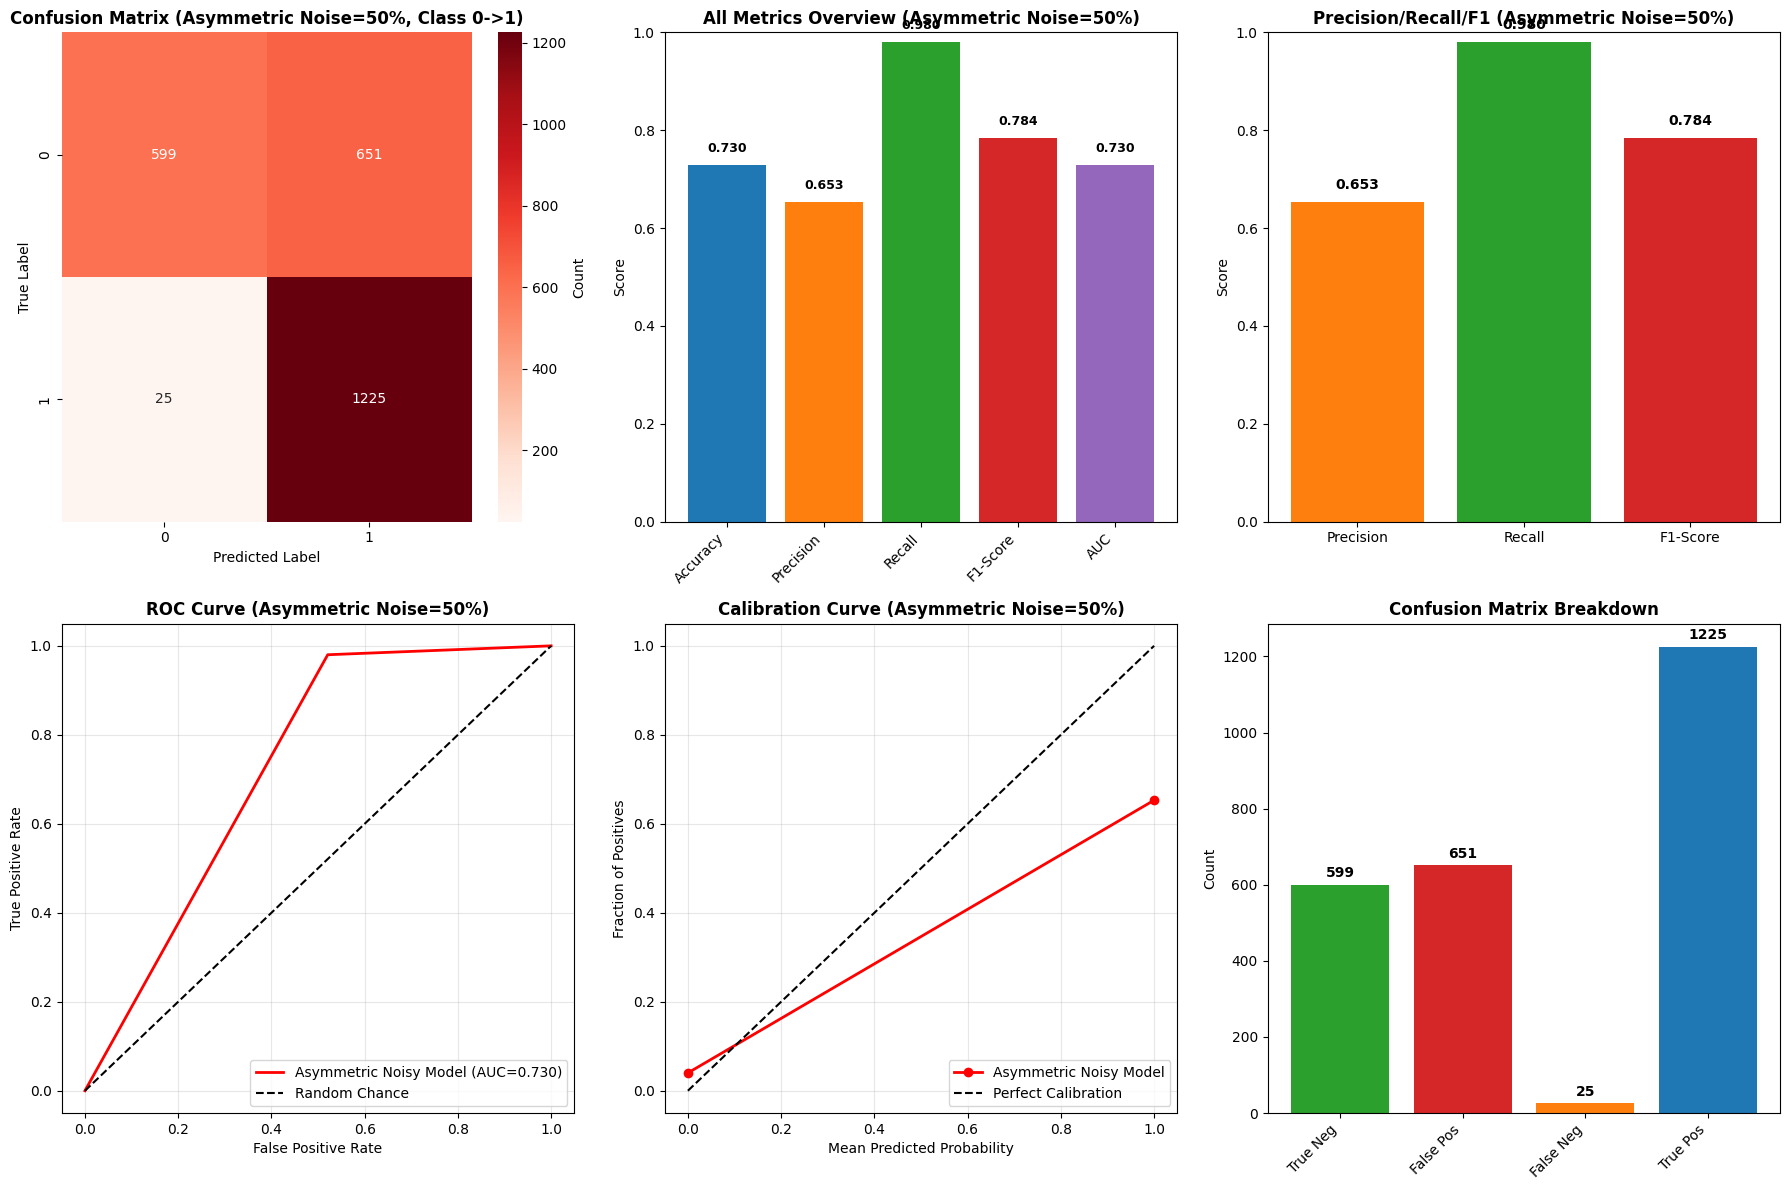


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.96      0.48      0.64      1250
     Default       0.65      0.98      0.78      1250

    accuracy                           0.73      2500
   macro avg       0.81      0.73      0.71      2500
weighted avg       0.81      0.73      0.71      2500



In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx = np.where(y_noisy == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 0
p = 0.50
y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Asymmetric Noise, 1 to 0, 10%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4125 3375]
Flipped class 1 -> 0 at rate 0.1

DECISION TREE WITH 10% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.9140
Precision: 0.9641
Recall:    0.8600
F1 Score:  0.9091
AUC Score: 0.9140



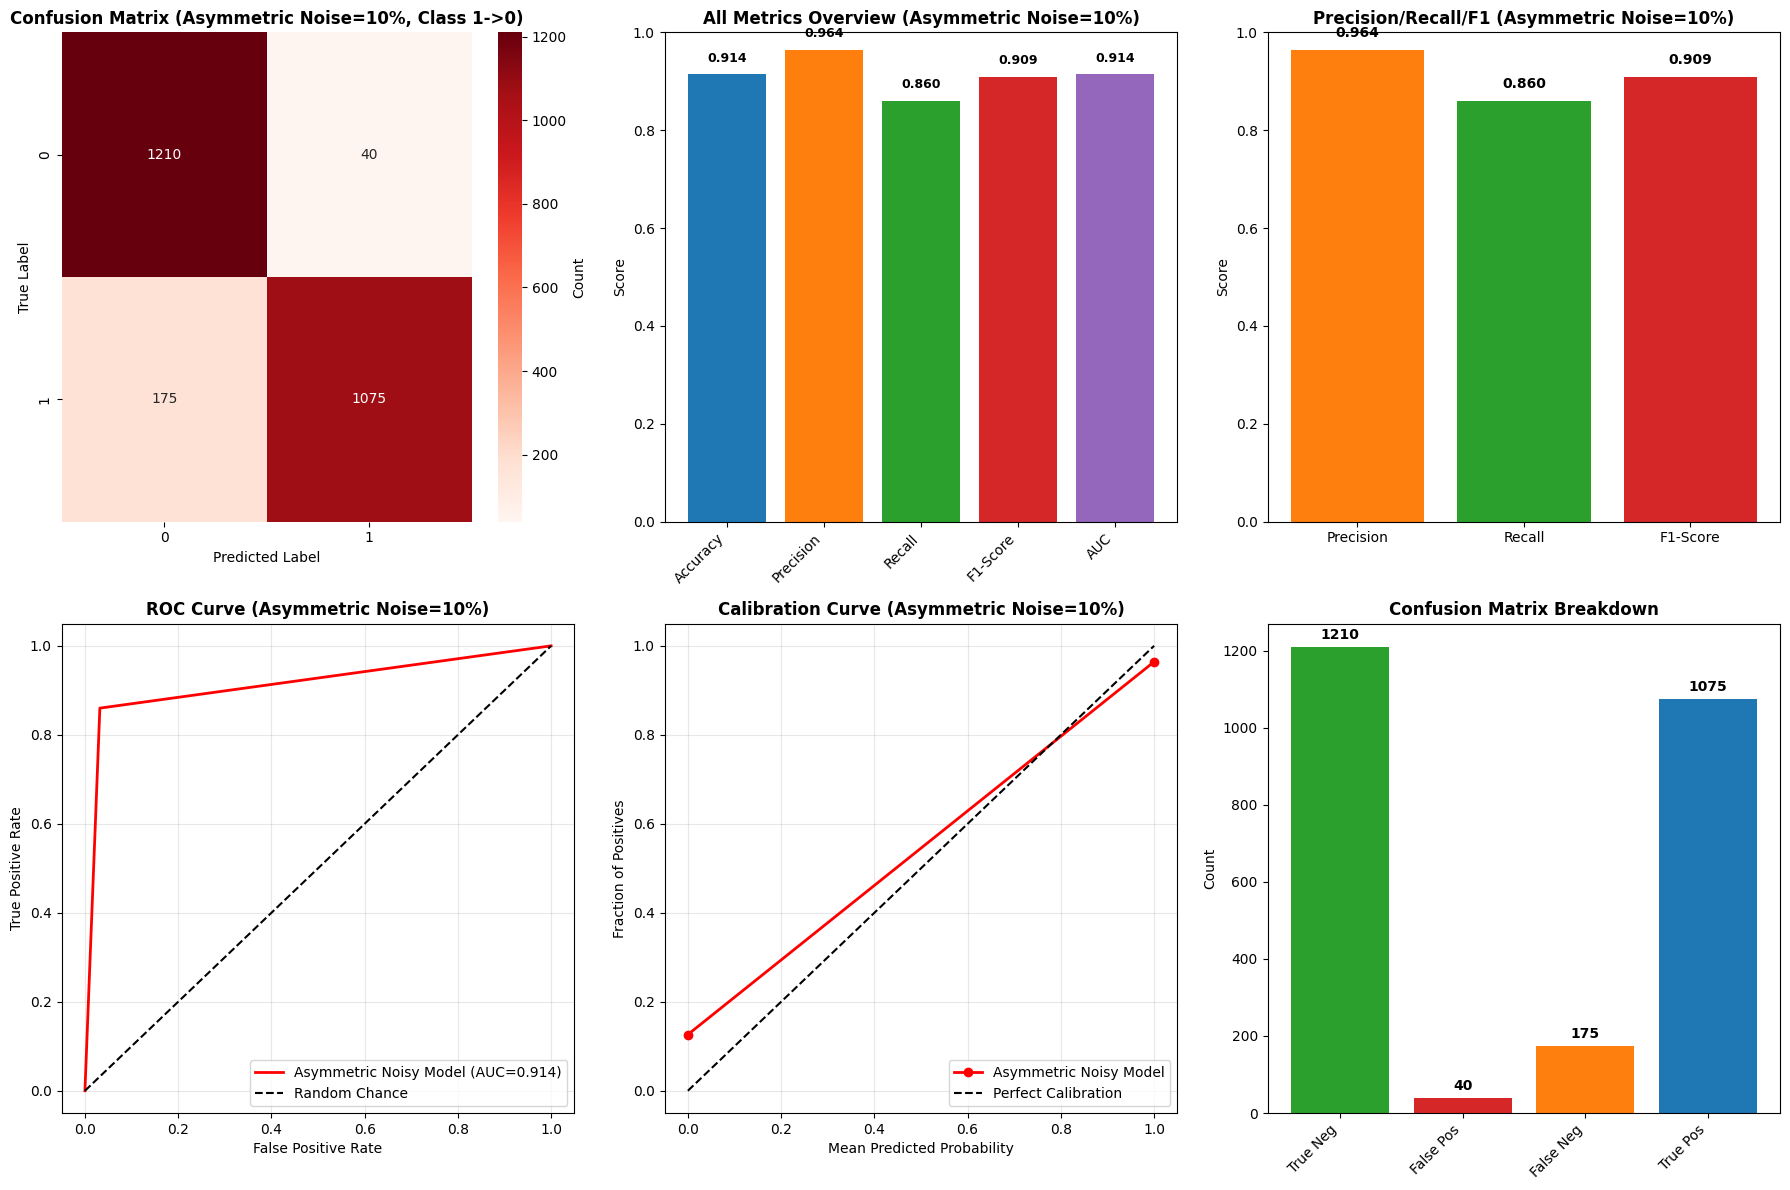


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.87      0.97      0.92      1250
     Default       0.96      0.86      0.91      1250

    accuracy                           0.91      2500
   macro avg       0.92      0.91      0.91      2500
weighted avg       0.92      0.91      0.91      2500



In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx = np.where(y_noisy == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 1
p = 0.10
y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4500 3000]
Flipped class 1 -> 0 at rate 0.2

DECISION TREE WITH 20% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.8644
Precision: 0.9681
Recall:    0.7536
F1 Score:  0.8475
AUC Score: 0.8644



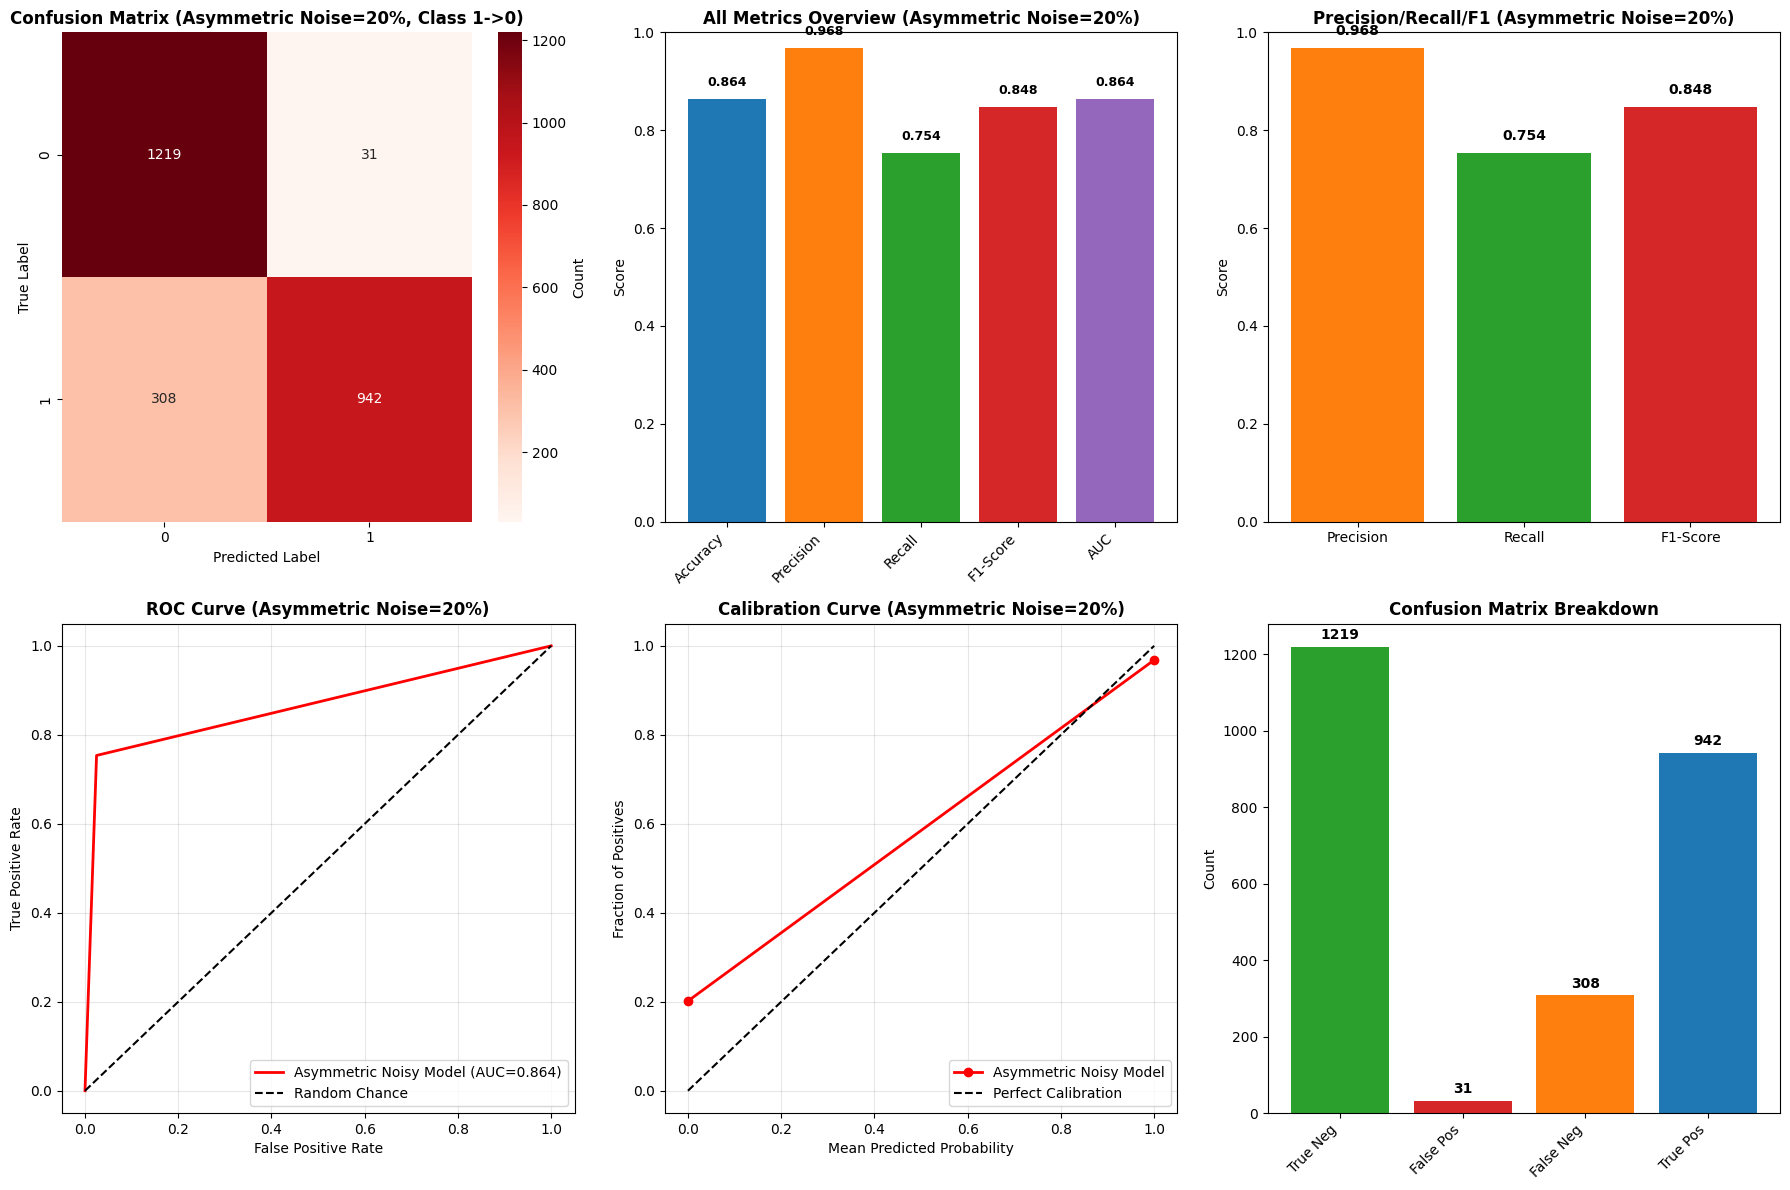


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.80      0.98      0.88      1250
     Default       0.97      0.75      0.85      1250

    accuracy                           0.86      2500
   macro avg       0.88      0.86      0.86      2500
weighted avg       0.88      0.86      0.86      2500



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx = np.where(y_noisy == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 1
p = 0.20
y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4987 2513]
Flipped class 1 -> 0 at rate 0.33

DECISION TREE WITH 33% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.8068
Precision: 0.9717
Recall:    0.6320
F1 Score:  0.7659
AUC Score: 0.8068



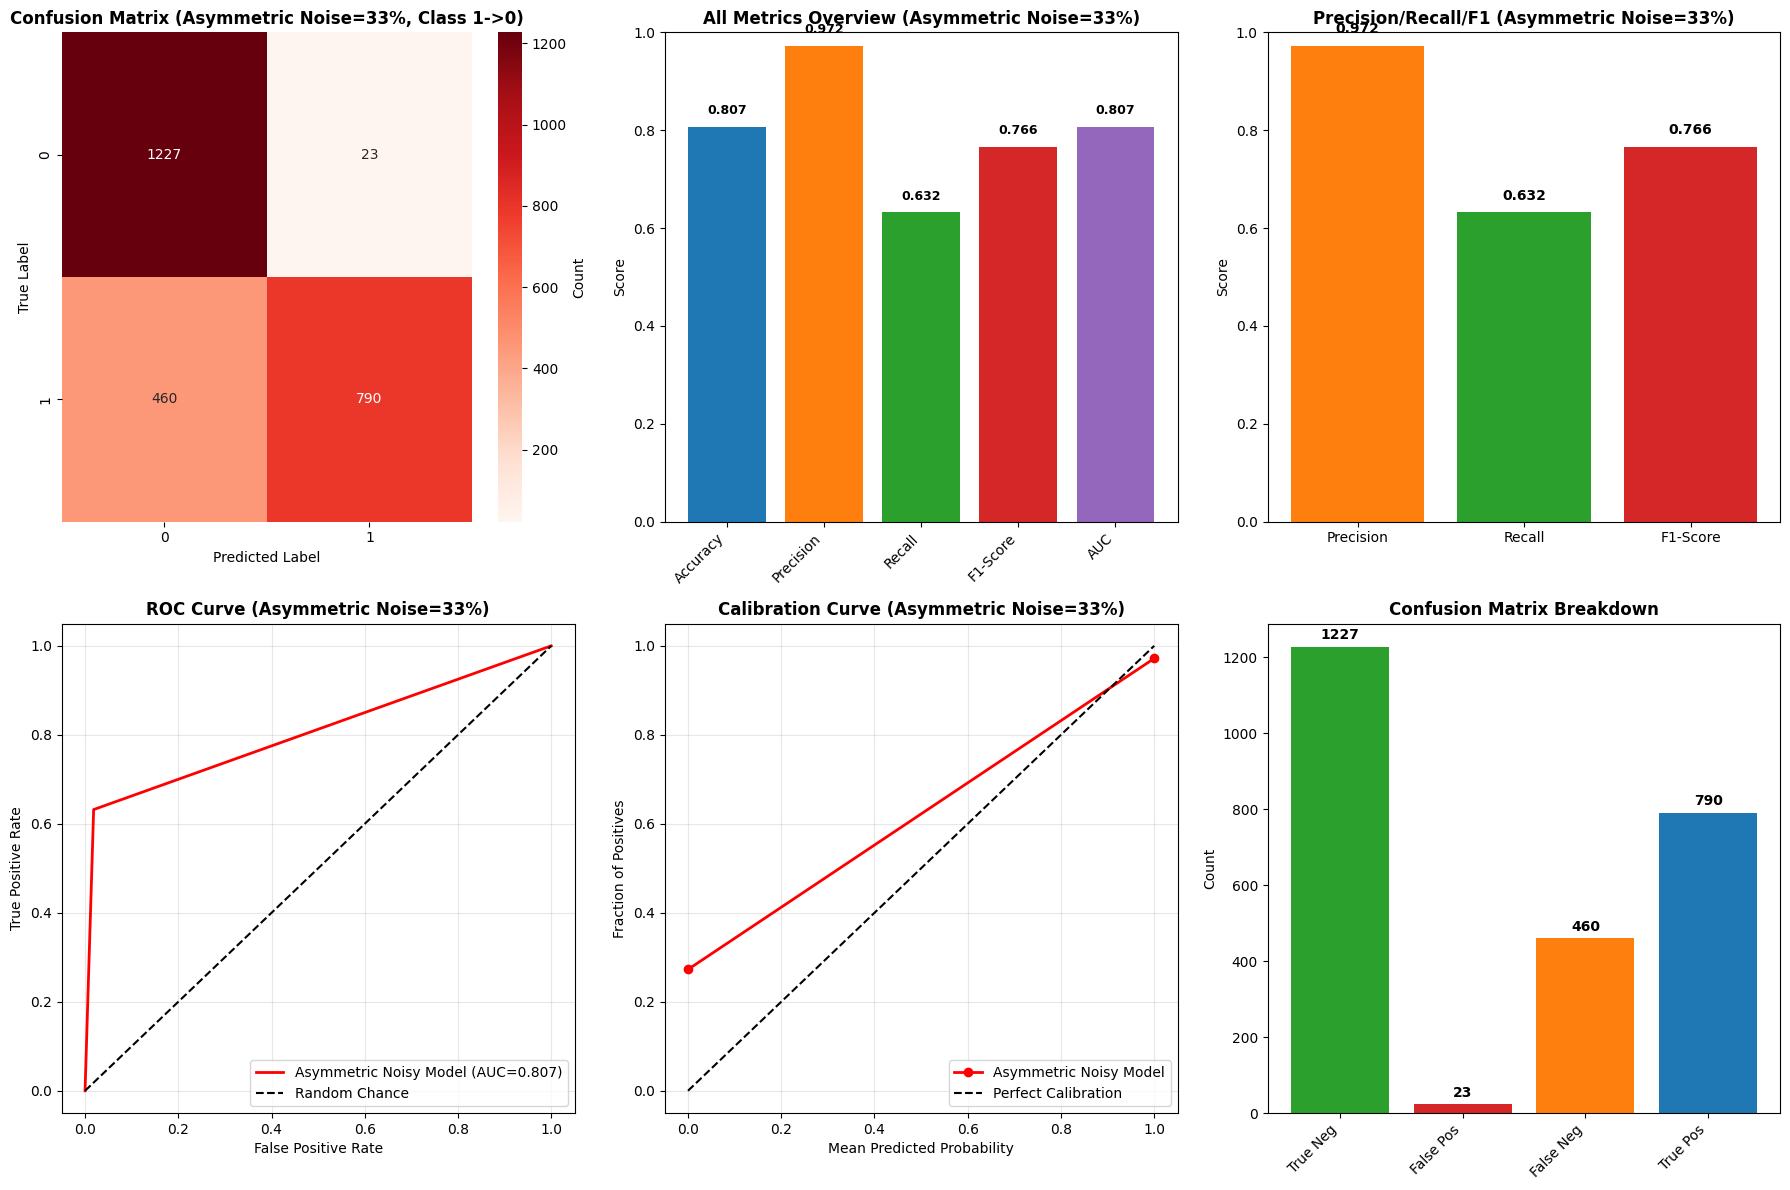


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.73      0.98      0.84      1250
     Default       0.97      0.63      0.77      1250

    accuracy                           0.81      2500
   macro avg       0.85      0.81      0.80      2500
weighted avg       0.85      0.81      0.80      2500



In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx = np.where(y_noisy == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 1
p = 0.33
y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [5625 1875]
Flipped class 1 -> 0 at rate 0.5

DECISION TREE WITH 50% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.7360
Precision: 0.9653
Recall:    0.4896
F1 Score:  0.6497
AUC Score: 0.7360



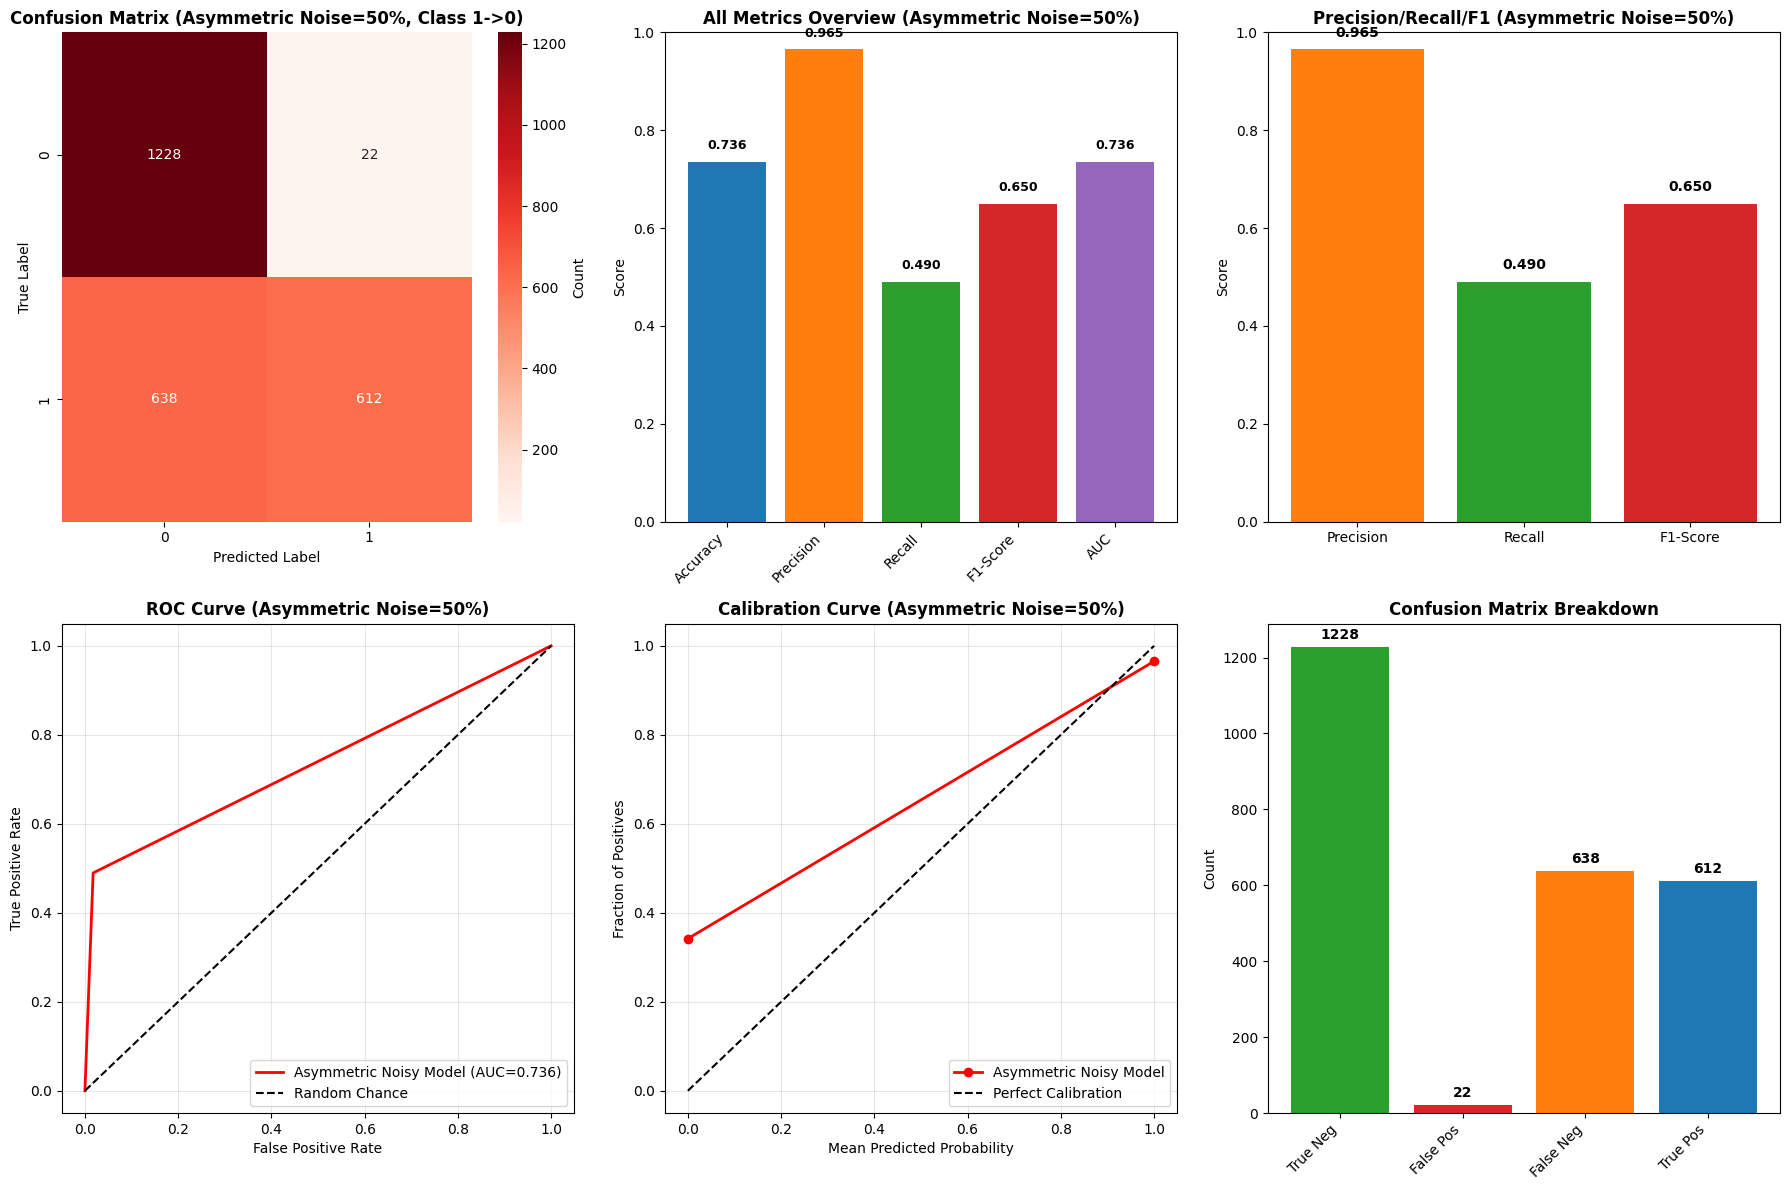


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.66      0.98      0.79      1250
     Default       0.97      0.49      0.65      1250

    accuracy                           0.74      2500
   macro avg       0.81      0.74      0.72      2500
weighted avg       0.81      0.74      0.72      2500



In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx = np.where(y_noisy == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 1
p = 0.50
y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Noise 3 = Randomly pick 10% of labels and flip them.

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3770 3730]
Random flip rate: 0.1

DECISION TREE WITH 10% RANDOM LABEL FLIP
Accuracy:  0.8596
Precision: 0.8548
Recall:    0.8664
F1 Score:  0.8605
AUC Score: 0.8596



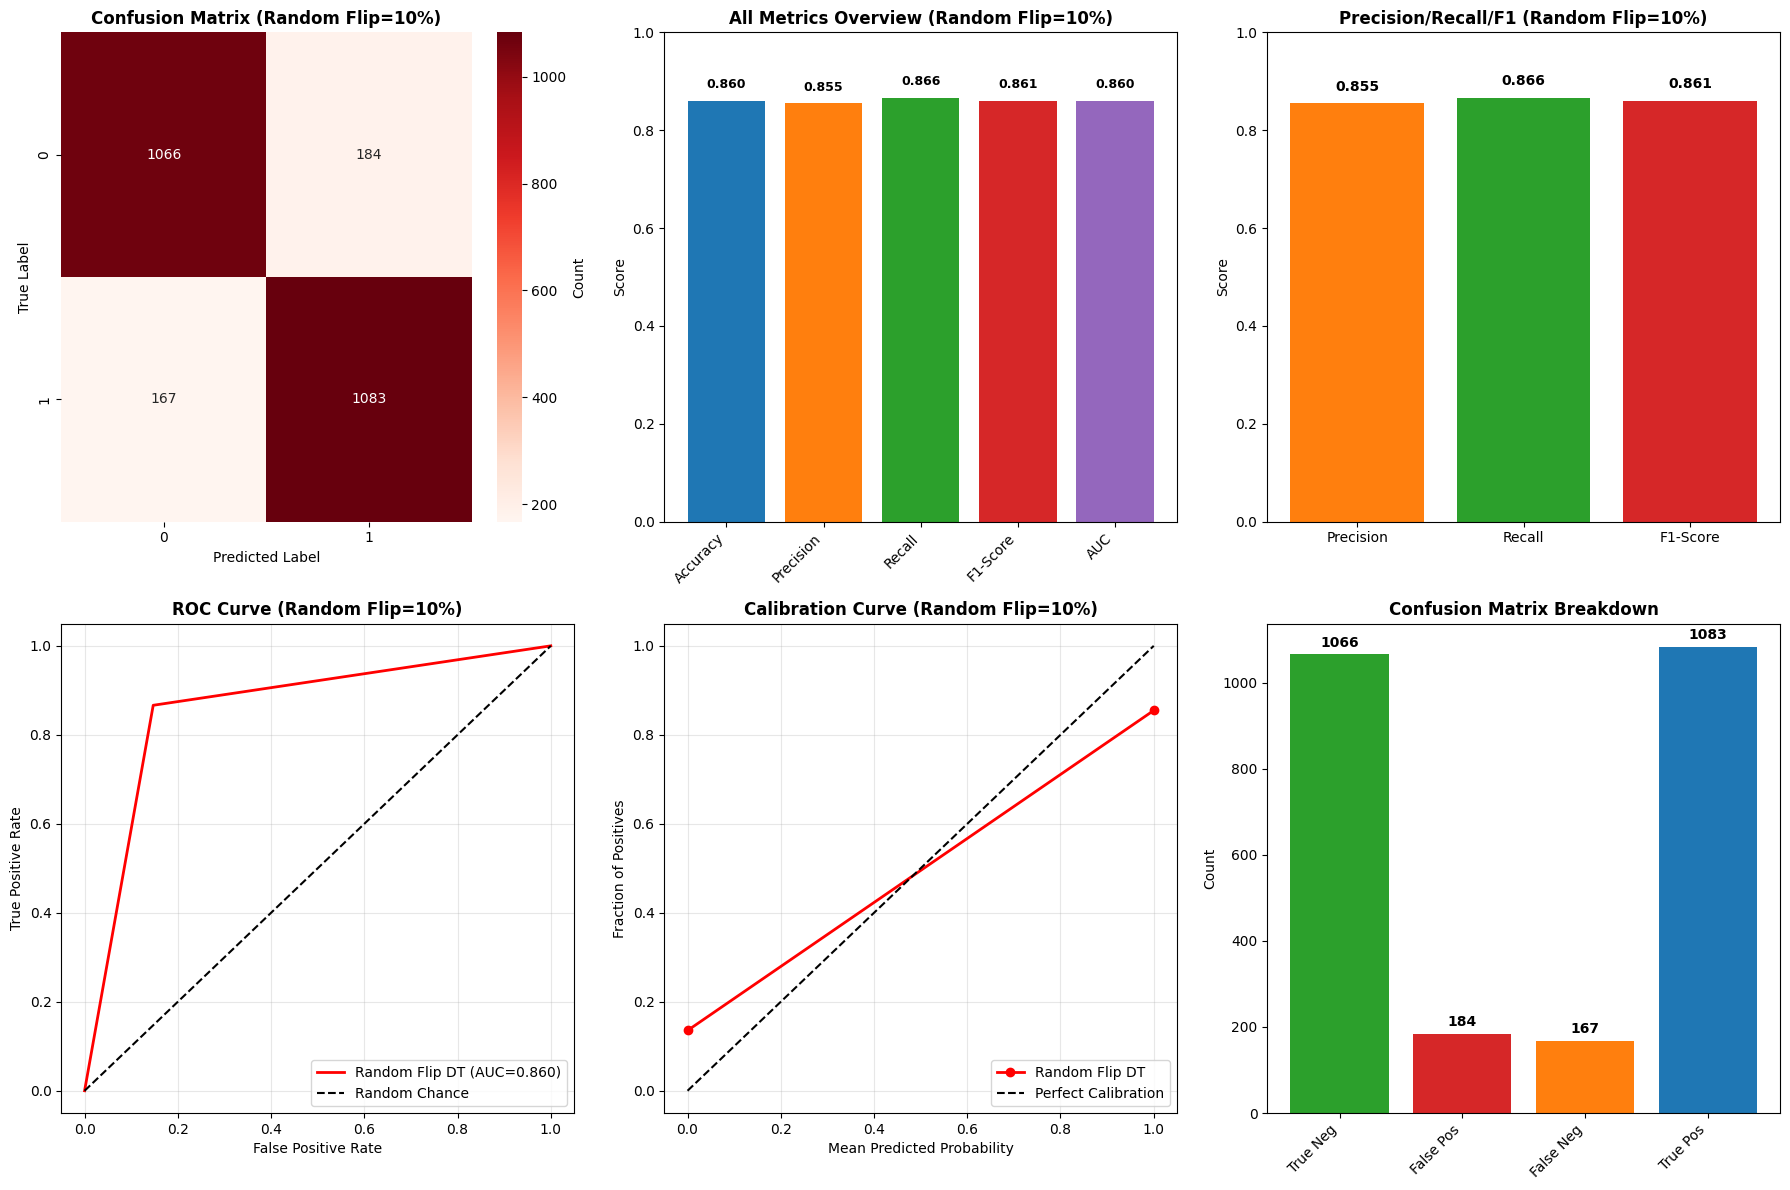


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.86      0.85      0.86      1250
     Default       0.85      0.87      0.86      1250

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.10
y_train_noisy = inject_random_label_flip(y_train, flip_rate)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3752 3748]
Random flip rate: 0.2

DECISION TREE WITH 20% RANDOM LABEL FLIP
Accuracy:  0.7676
Precision: 0.7571
Recall:    0.7880
F1 Score:  0.7722
AUC Score: 0.7676



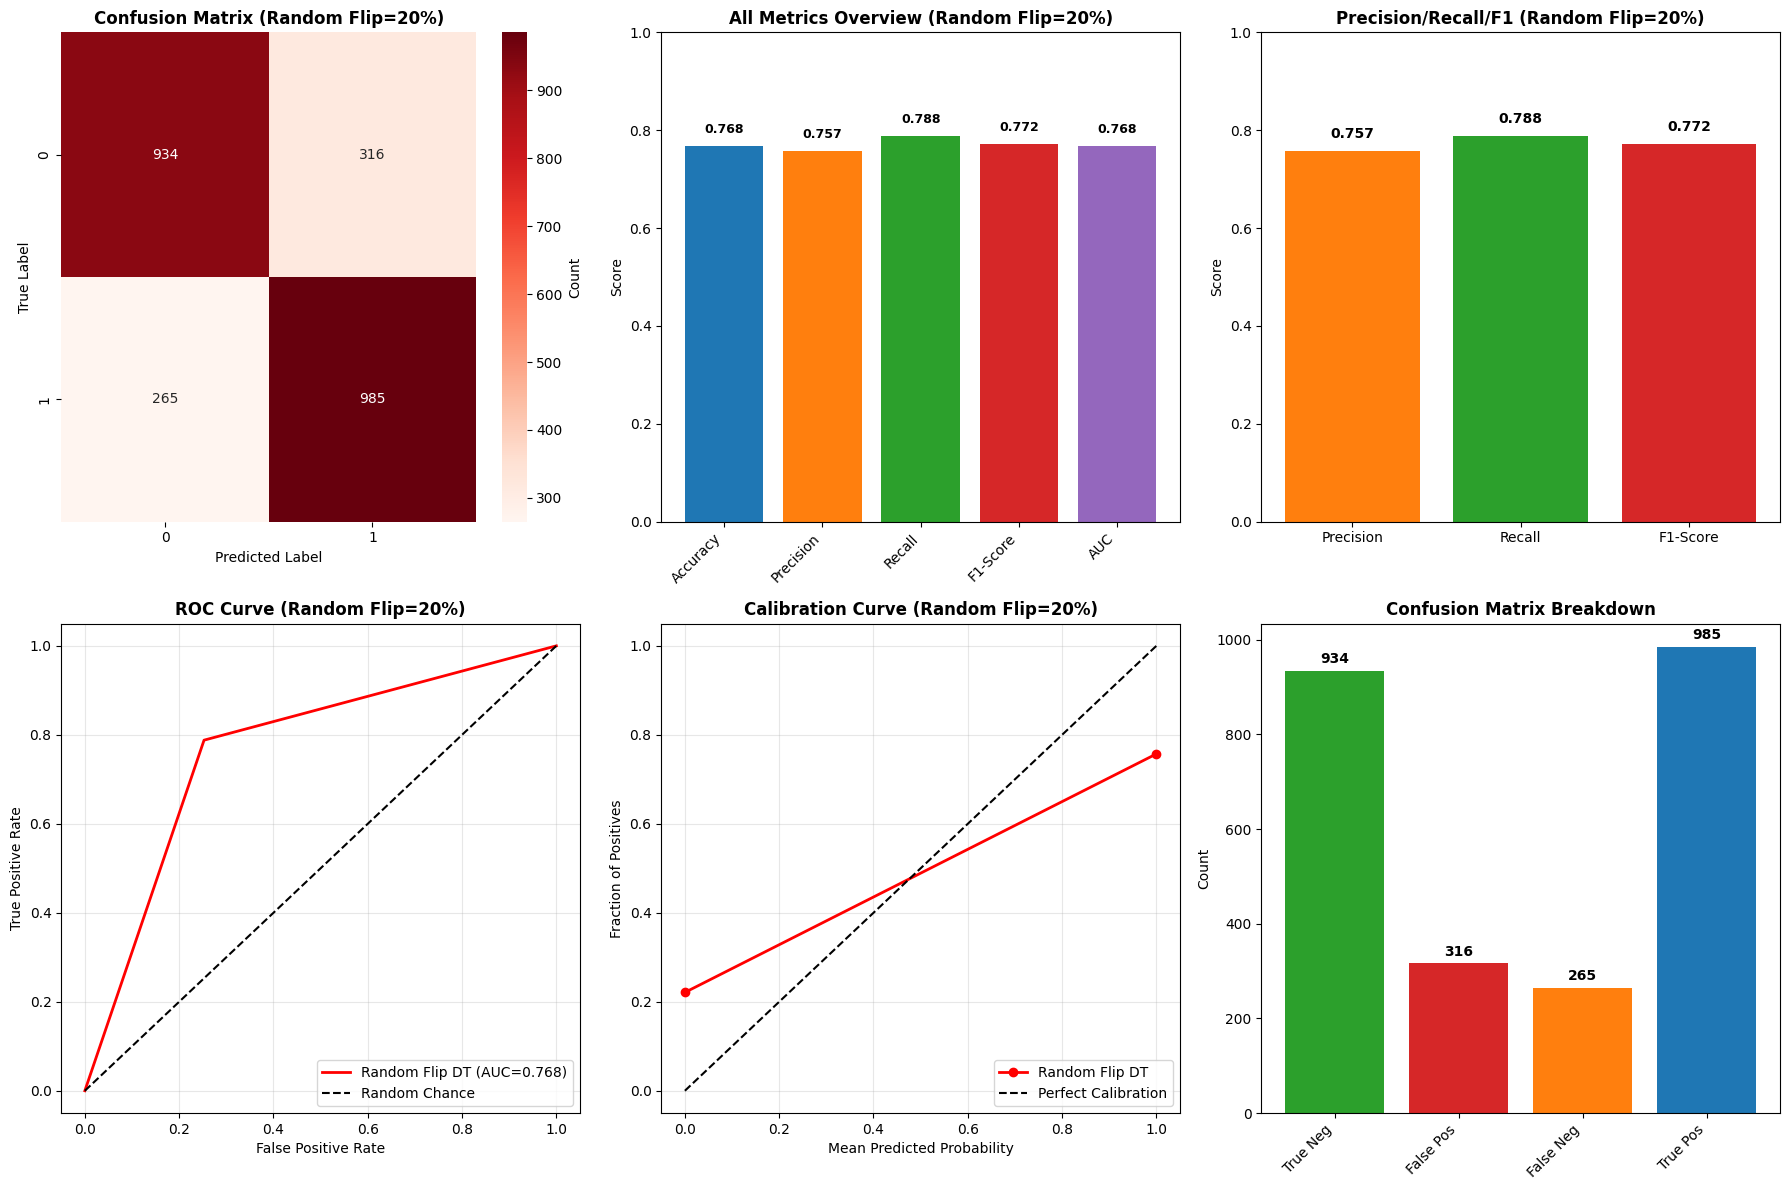


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.78      0.75      0.76      1250
     Default       0.76      0.79      0.77      1250

    accuracy                           0.77      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.77      0.77      0.77      2500



In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.20
y_train_noisy = inject_random_label_flip(y_train, flip_rate)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3743 3757]
Random flip rate: 0.33

DECISION TREE WITH 33% RANDOM LABEL FLIP
Accuracy:  0.6528
Precision: 0.6478
Recall:    0.6696
F1 Score:  0.6585
AUC Score: 0.6528



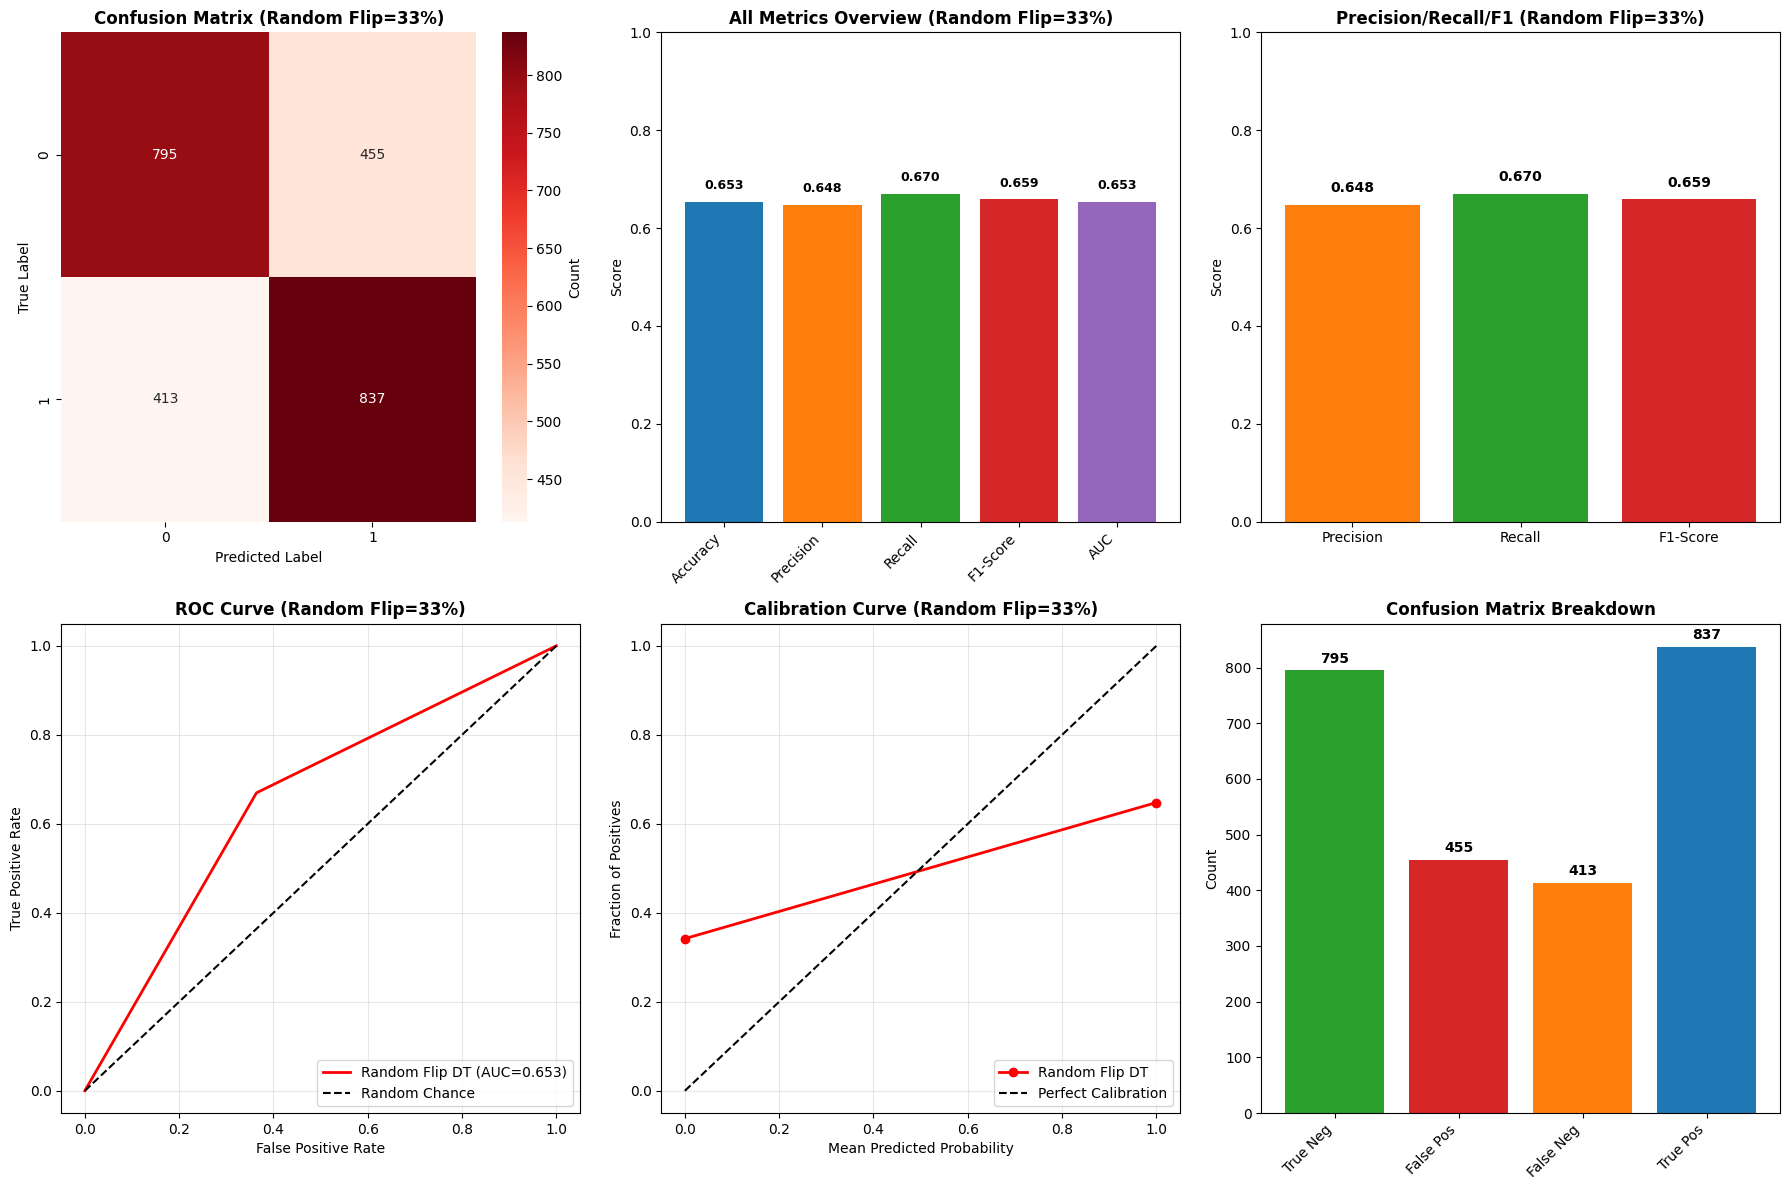


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.66      0.64      0.65      1250
     Default       0.65      0.67      0.66      1250

    accuracy                           0.65      2500
   macro avg       0.65      0.65      0.65      2500
weighted avg       0.65      0.65      0.65      2500



In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.33
y_train_noisy = inject_random_label_flip(y_train, flip_rate)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3826 3674]
Random flip rate: 0.5

DECISION TREE WITH 50% RANDOM LABEL FLIP
Accuracy:  0.5052
Precision: 0.5051
Recall:    0.5104
F1 Score:  0.5078
AUC Score: 0.5052



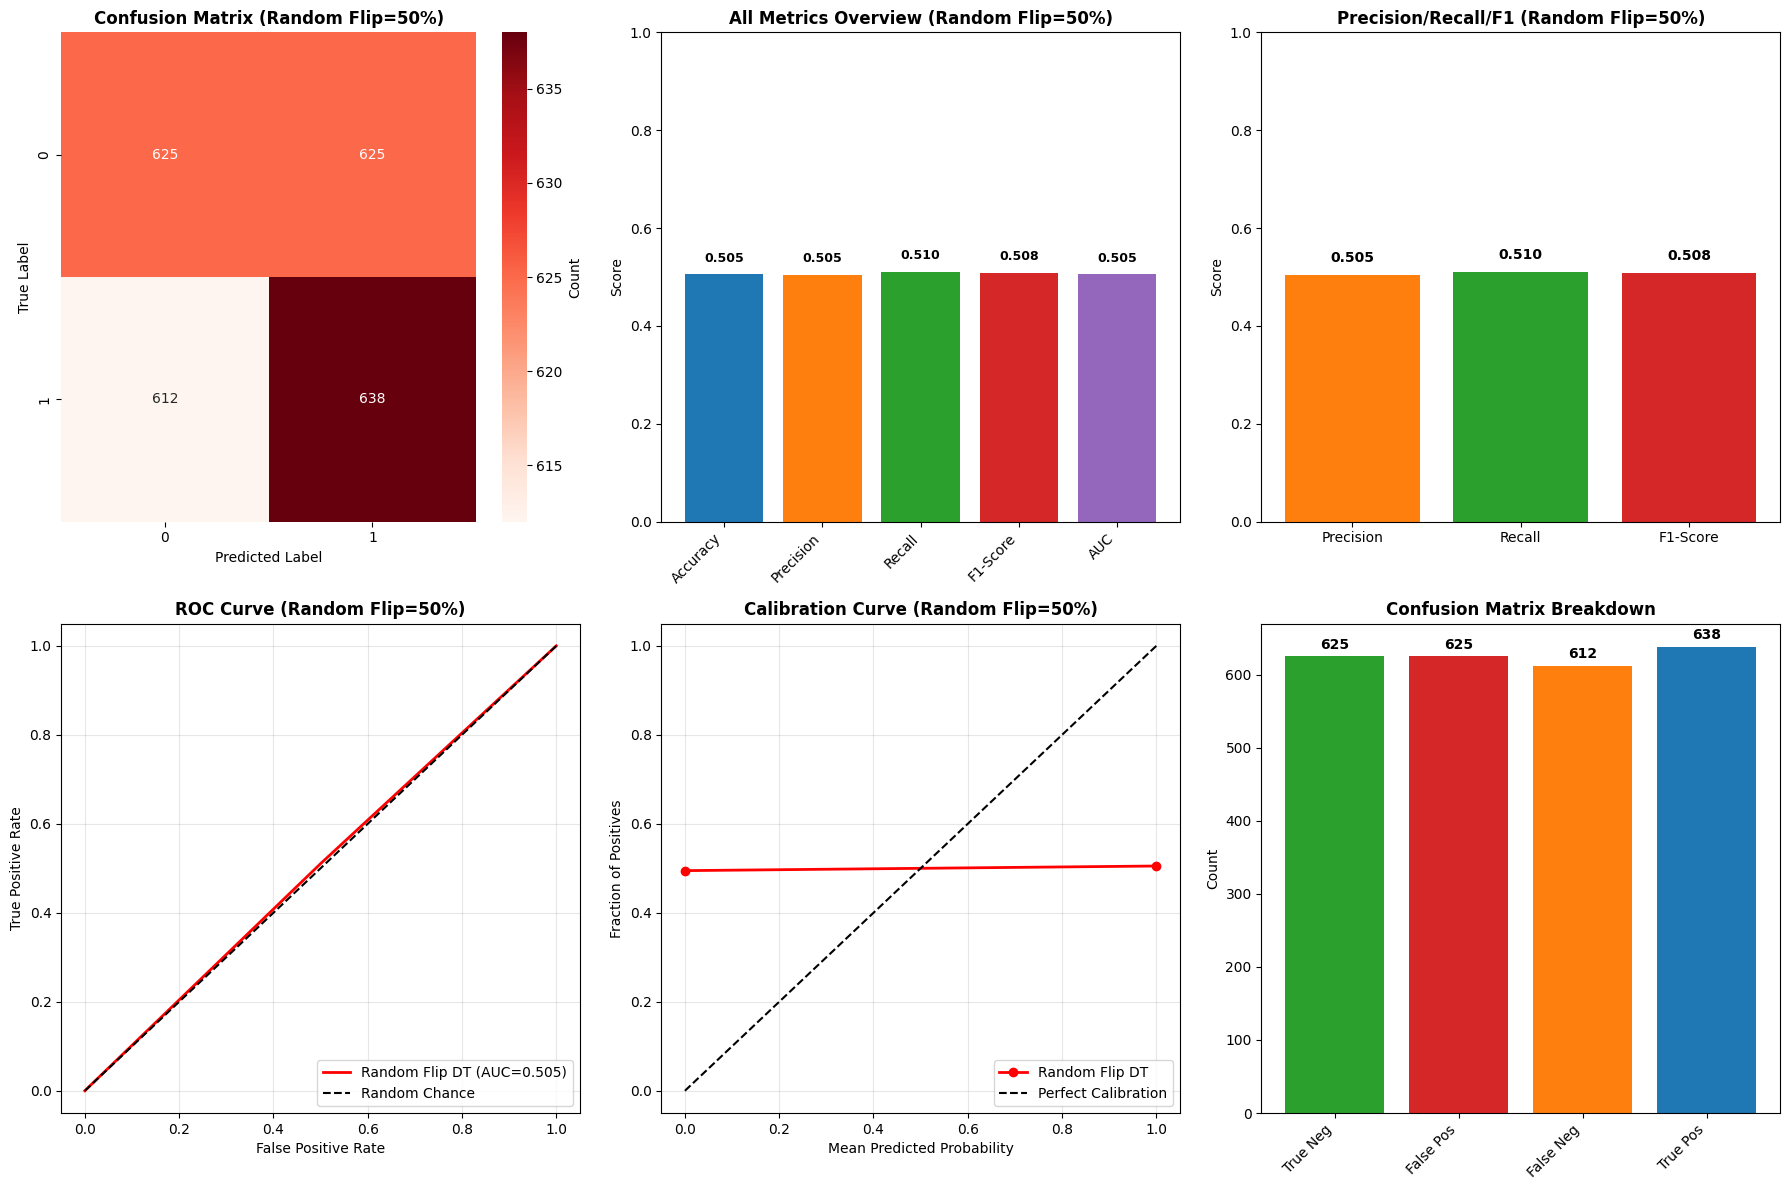


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.51      0.50      0.50      1250
     Default       0.51      0.51      0.51      1250

    accuracy                           0.51      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.51      0.51      0.51      2500



In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.50
y_train_noisy = inject_random_label_flip(y_train, flip_rate)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise) 0->1(20%) and 1->0(5%)

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [3225 4275]
Noise rates: 0→1=0.2, 1→0=0.05

DECISION TREE WITH CONFUSION MATRIX NOISE (0→1=0.2, 1→0=0.05)
Accuracy:  0.8516
Precision: 0.8037
Recall:    0.9304
F1 Score:  0.8624
AUC Score: 0.8516



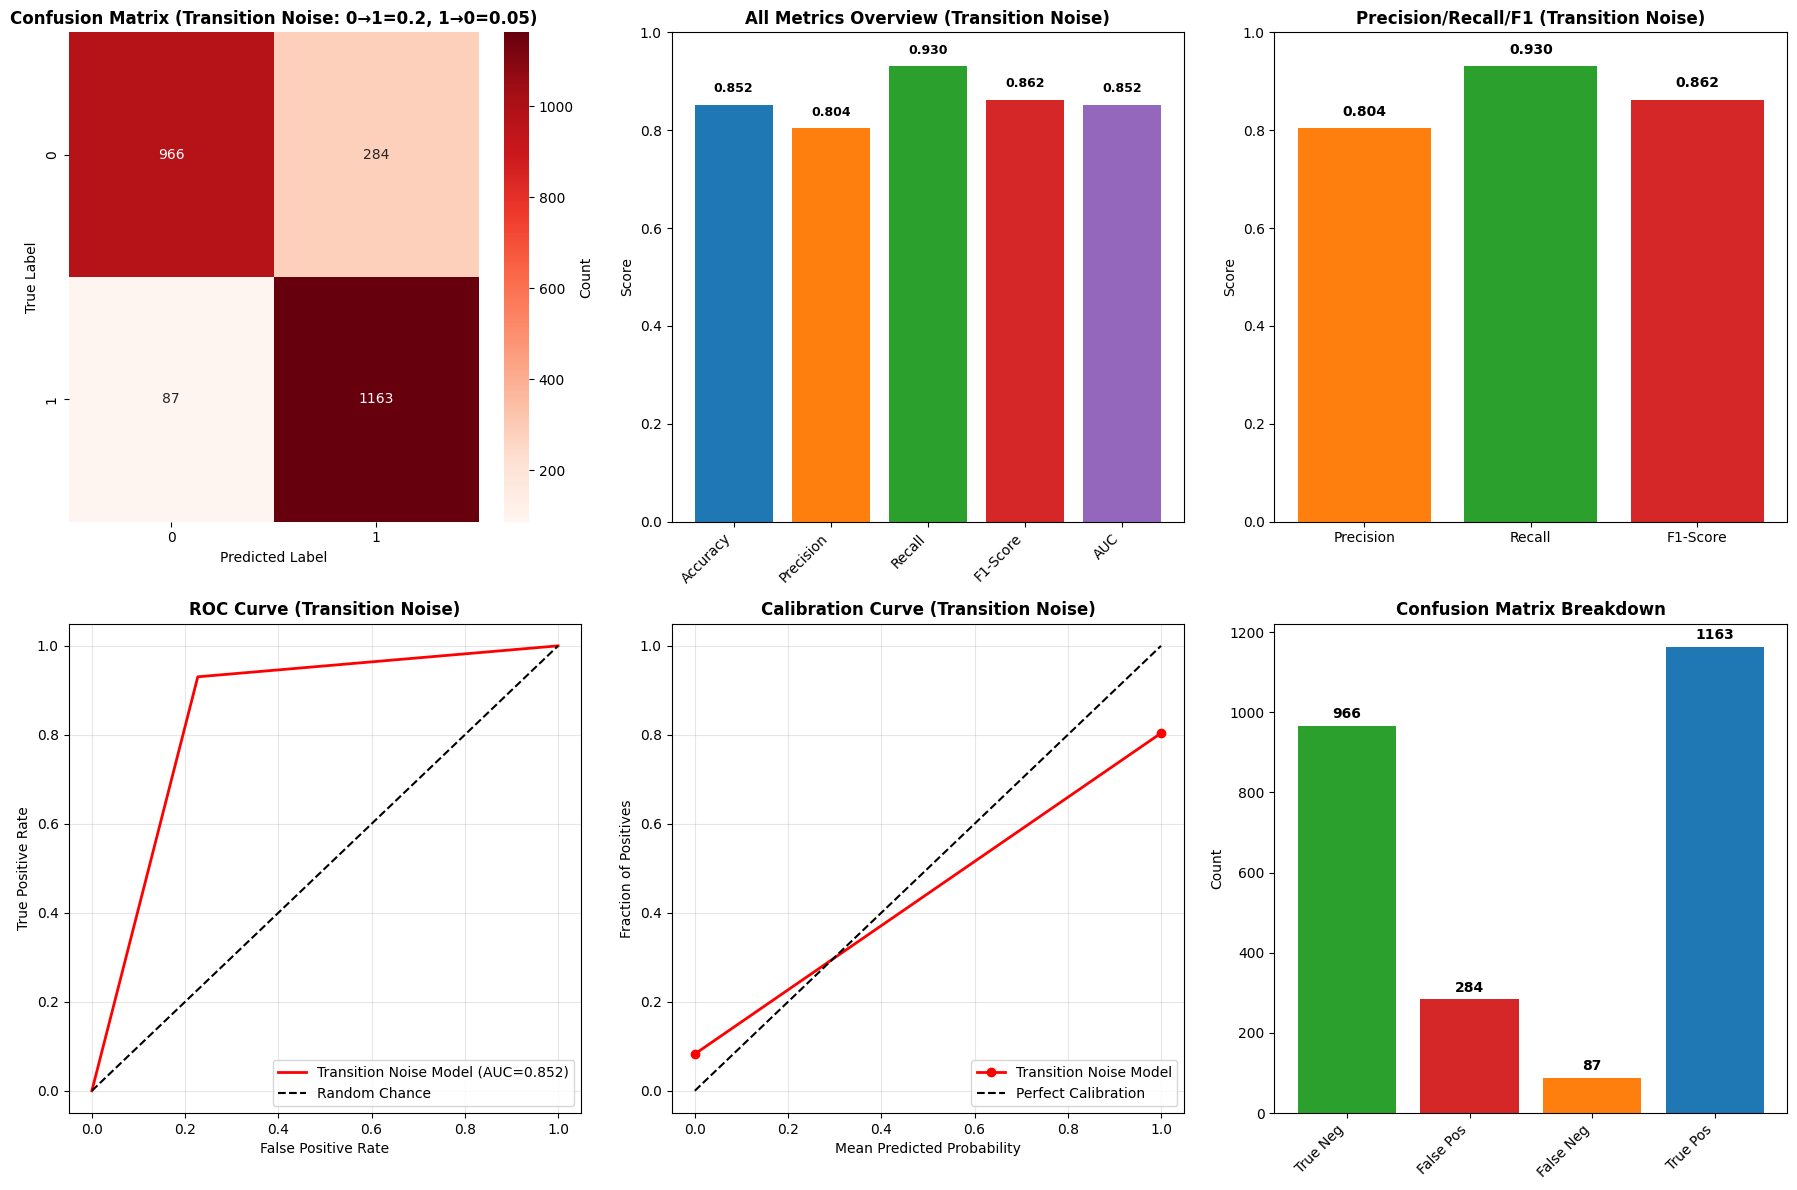


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.92      0.77      0.84      1250
     Default       0.80      0.93      0.86      1250

    accuracy                           0.85      2500
   macro avg       0.86      0.85      0.85      2500
weighted avg       0.86      0.85      0.85      2500



In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx0 = np.where(y_noisy == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    idx1 = np.where(y_noisy == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    return y_noisy

eta_01 = 0.20
eta_10 = 0.05
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [4350 3150]
Noise rates: 0→1=0.05, 1→0=0.2

DECISION TREE WITH CONFUSION MATRIX NOISE (0→1=0.05, 1→0=0.2)
Accuracy:  0.8472
Precision: 0.9033
Recall:    0.7776
F1 Score:  0.8358
AUC Score: 0.8472



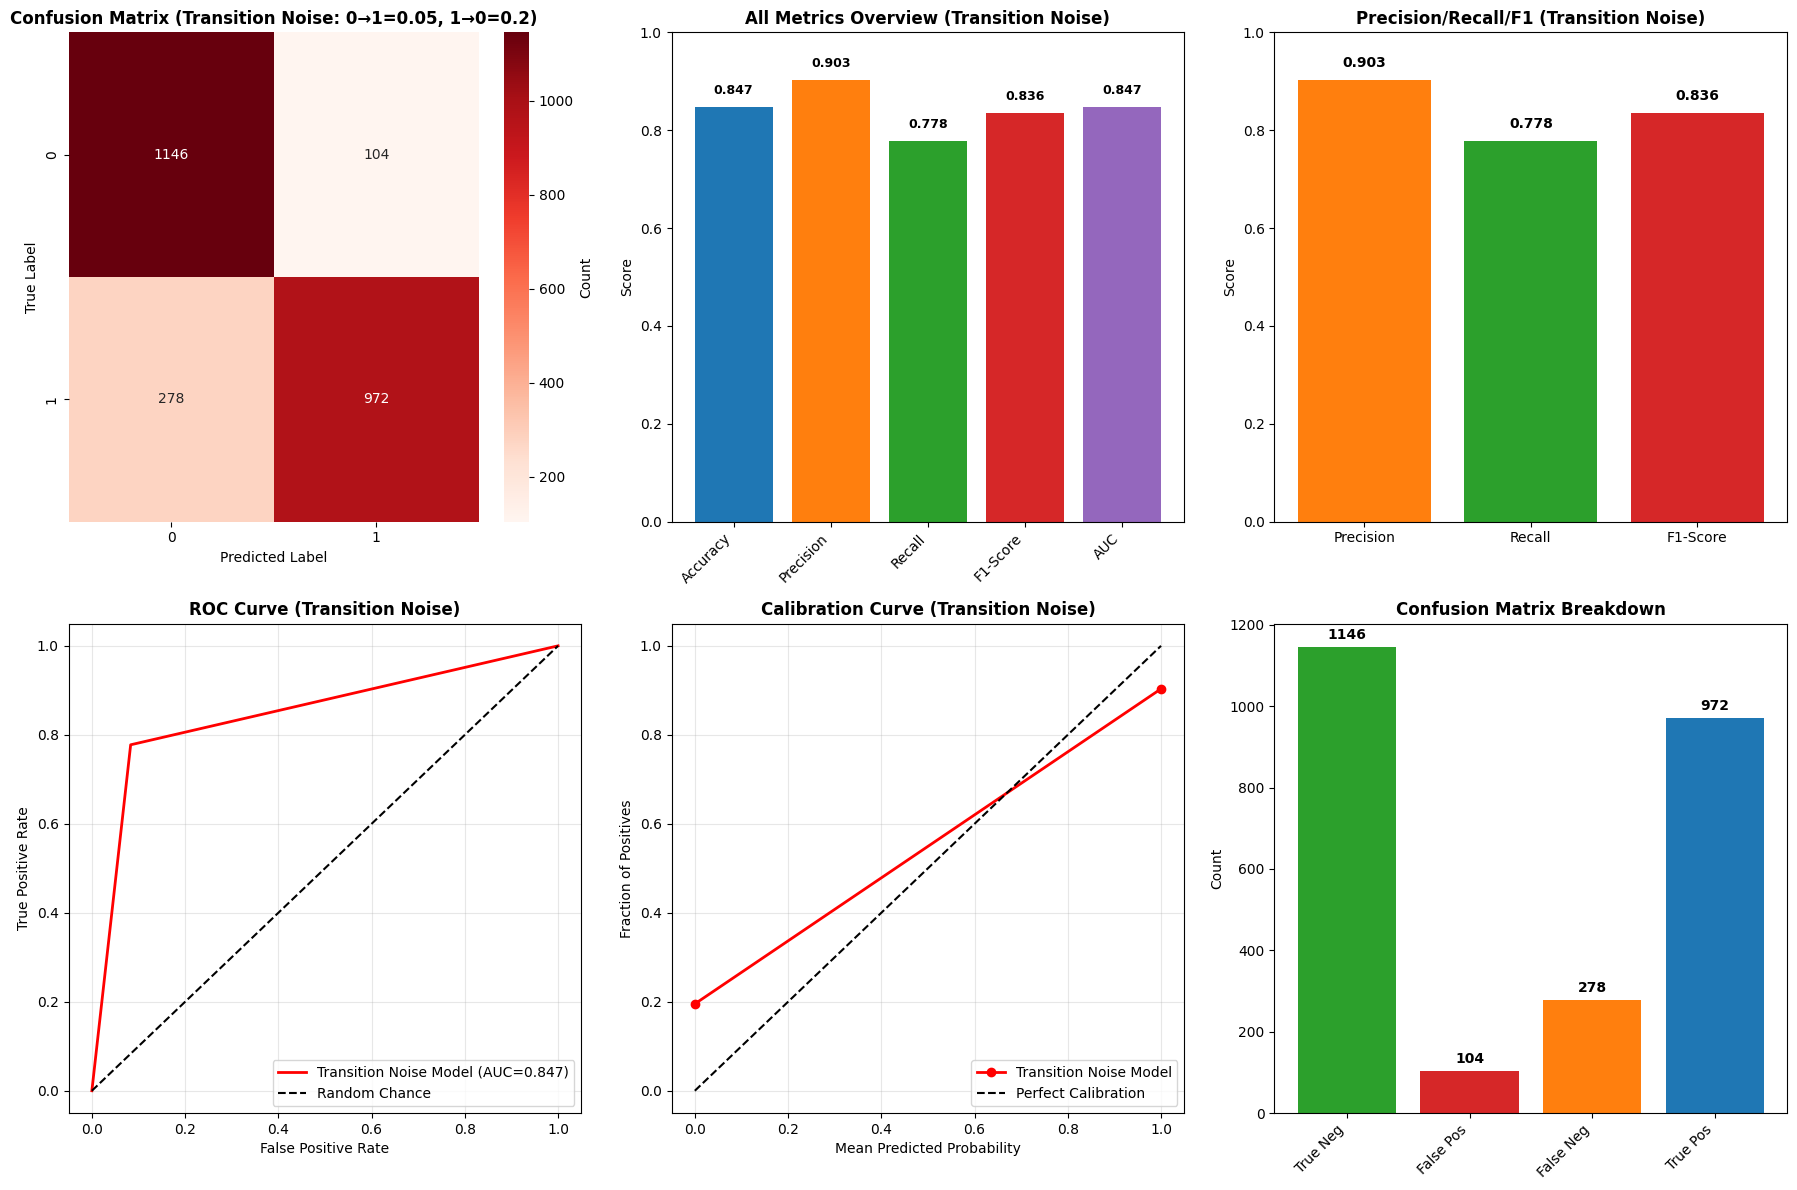


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.80      0.92      0.86      1250
     Default       0.90      0.78      0.84      1250

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx0 = np.where(y_noisy == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    idx1 = np.where(y_noisy == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    return y_noisy

eta_01 = 0.05
eta_10 = 0.20
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [2437 5063]
Noise rates: 0→1=0.5, 1→0=0.1

DECISION TREE WITH CONFUSION MATRIX NOISE (0→1=0.5, 1→0=0.1)
Accuracy:  0.7220
Precision: 0.6669
Recall:    0.8872
F1 Score:  0.7614
AUC Score: 0.7220



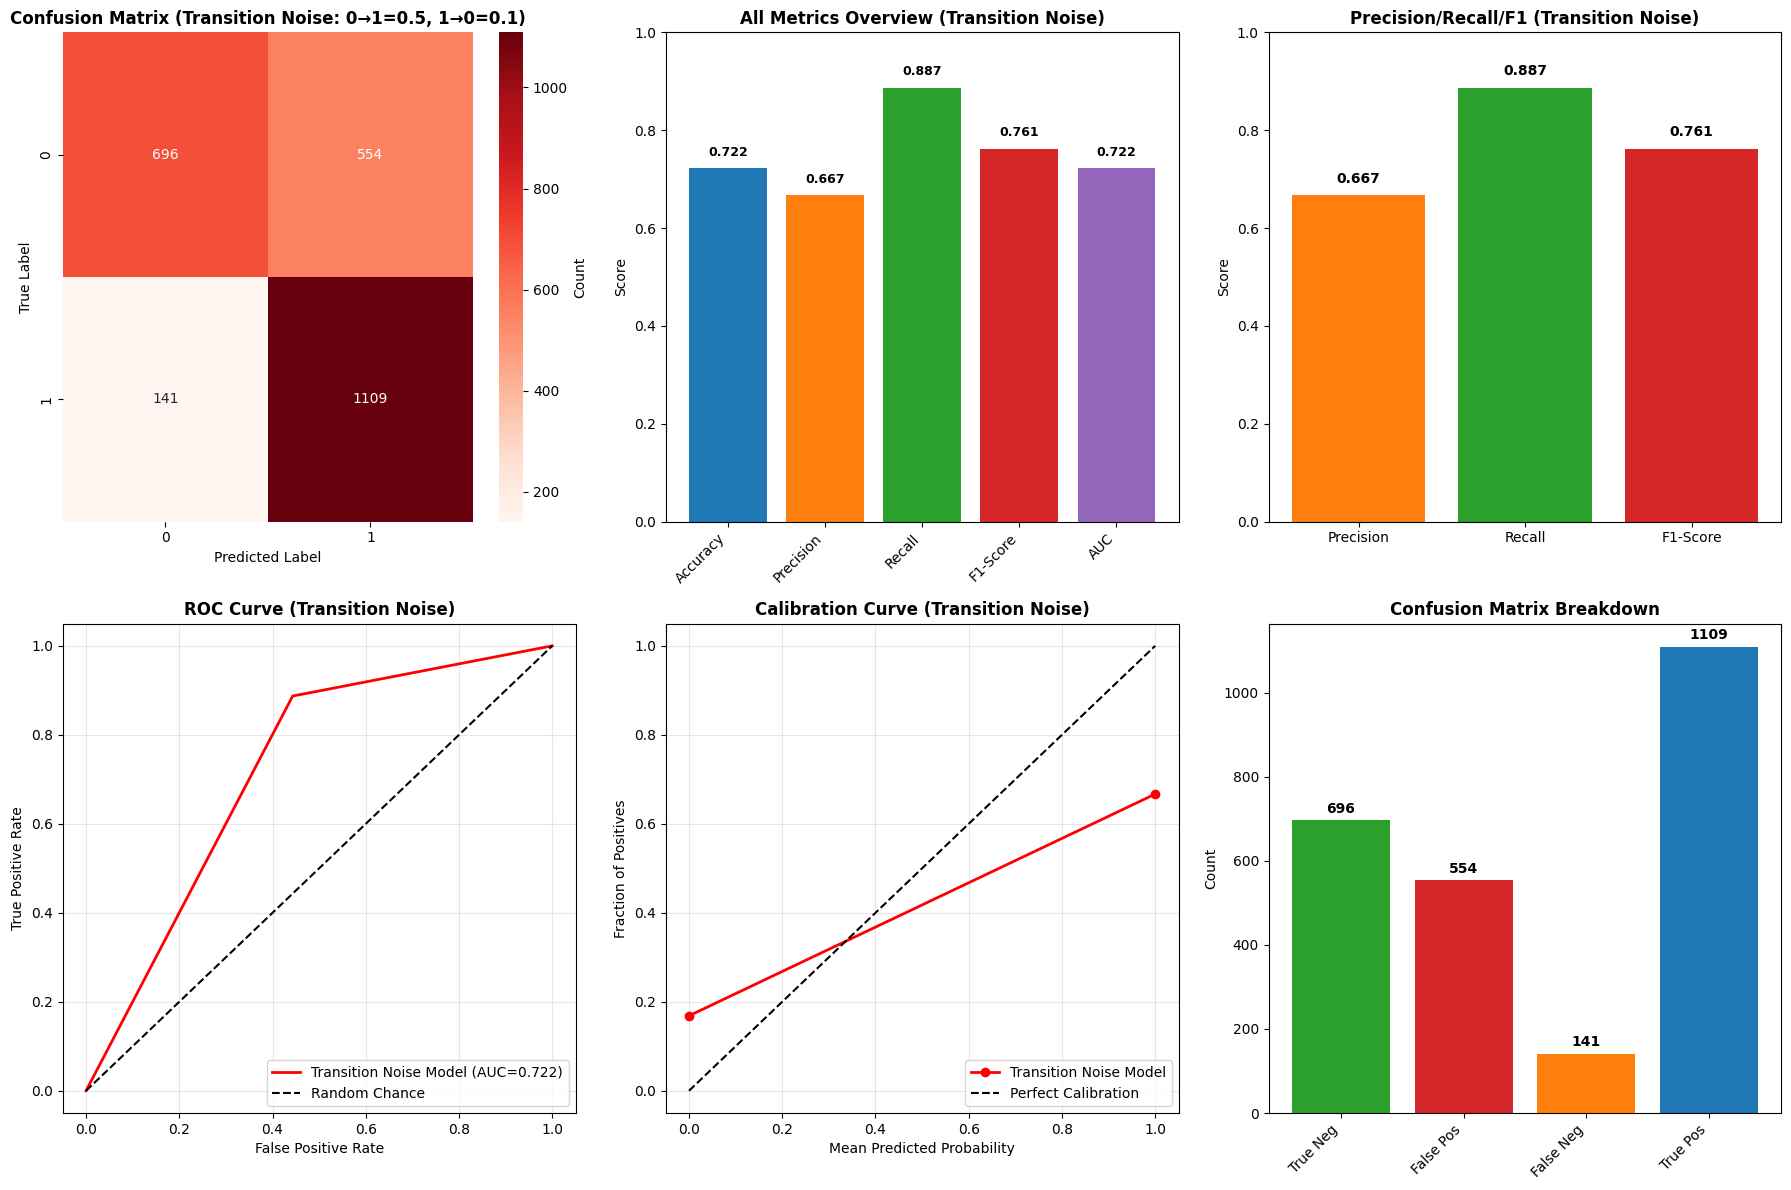


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.83      0.56      0.67      1250
     Default       0.67      0.89      0.76      1250

    accuracy                           0.72      2500
   macro avg       0.75      0.72      0.71      2500
weighted avg       0.75      0.72      0.71      2500



In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx0 = np.where(y_noisy == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    idx1 = np.where(y_noisy == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    return y_noisy

eta_01 = 0.50
eta_10 = 0.10
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Confusion matrix noisy label distribution: [5437 2063]
Noise rates: 0→1=0.1, 1→0=0.5

DECISION TREE WITH CONFUSION MATRIX NOISE (0→1=0.1, 1→0=0.5)
Accuracy:  0.6948
Precision: 0.8662
Recall:    0.4608
F1 Score:  0.6016
AUC Score: 0.6948



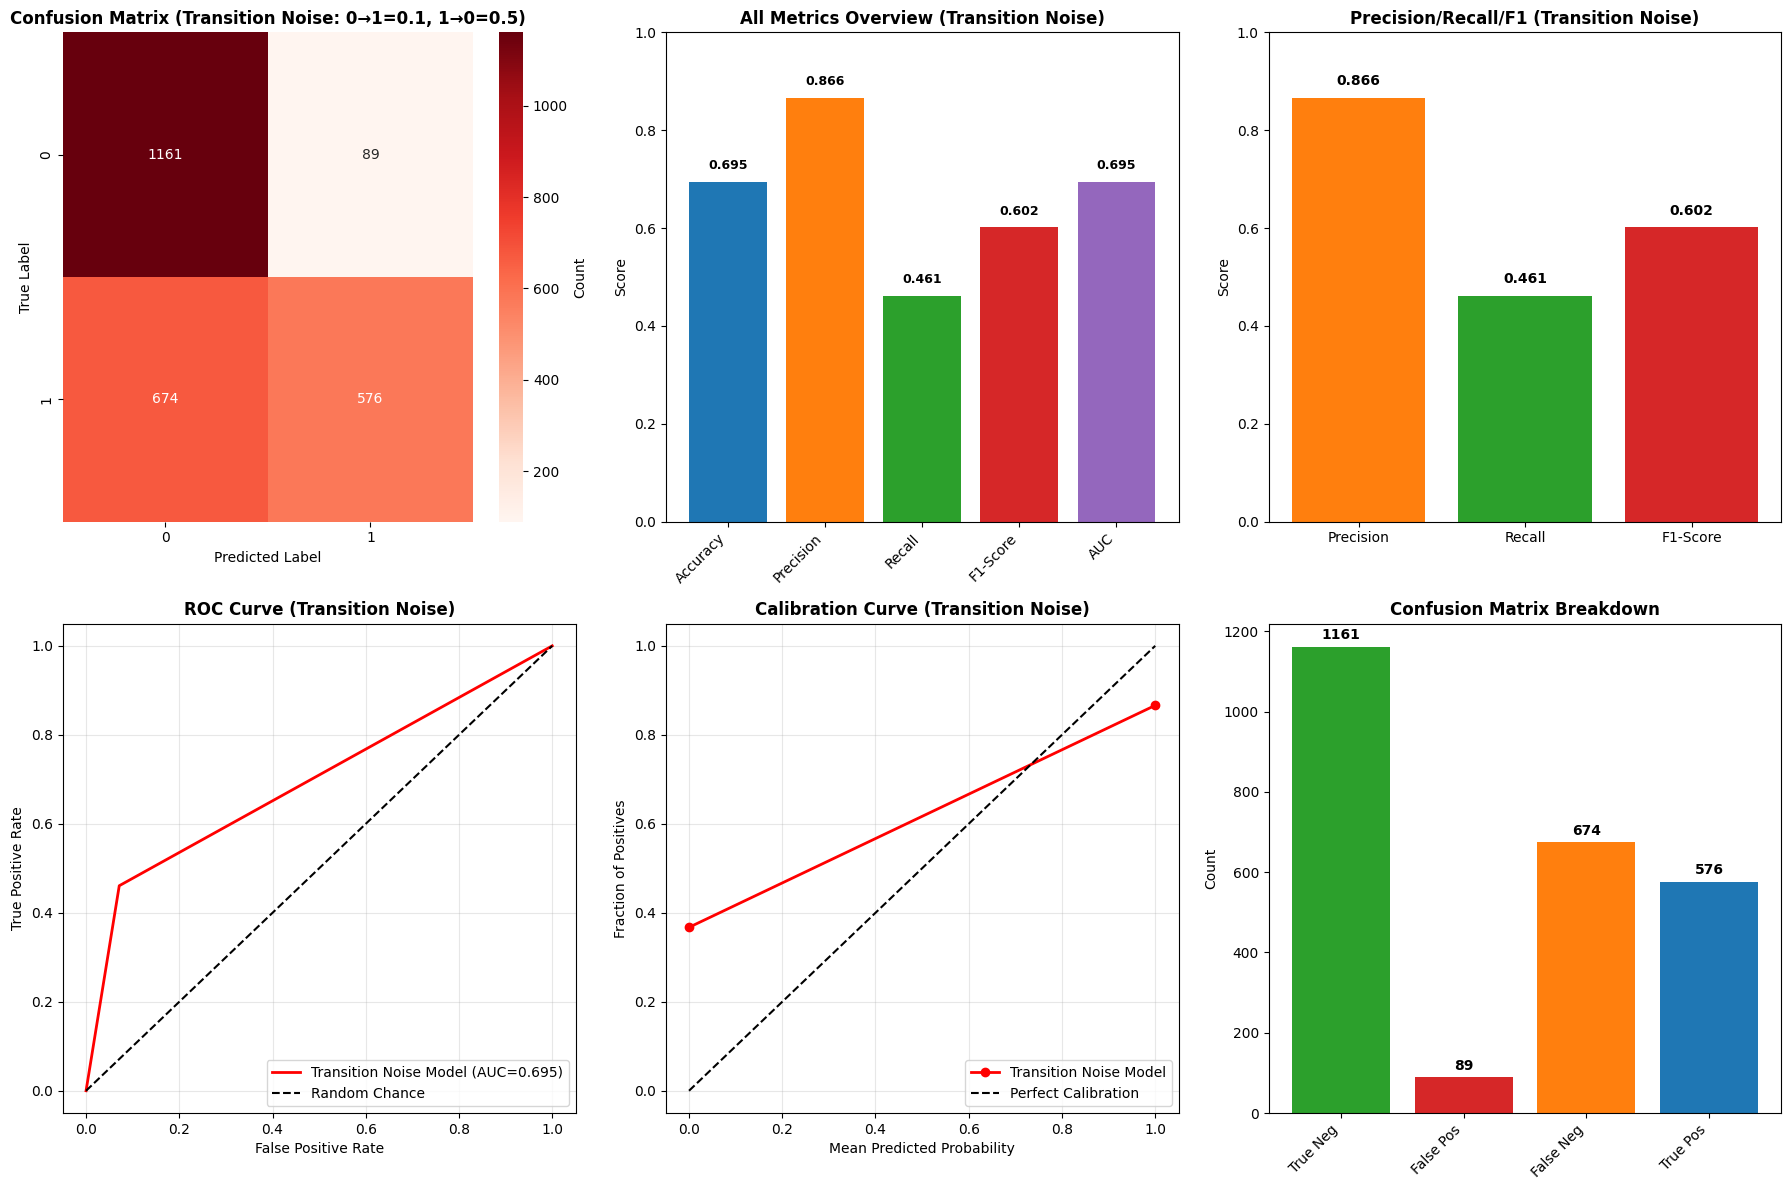


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.63      0.93      0.75      1250
     Default       0.87      0.46      0.60      1250

    accuracy                           0.69      2500
   macro avg       0.75      0.69      0.68      2500
weighted avg       0.75      0.69      0.68      2500



In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx0 = np.where(y_noisy == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1
    idx1 = np.where(y_noisy == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0
    return y_noisy

eta_01 = 0.10
eta_10 = 0.50
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Confusion matrix noisy label distribution:", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Transition Noise: 0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Transition Noise)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Transition Noise Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Transition Noise Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Transition Noise)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))